# HW8: Ada Boost for Committee Training of Nonlinearly Separable Classifiers

Blanca Miller
STAT 760
04.12.2018

__Objective:__ Create a data set containing a positive and negative class, where the positive class is a circle inside of the negative class, a square, and train a committee of classifiers using the adaptive boosting algorithm to make random cuts in the square. A series of "linear cuts" will combine to generate a classifier for the nonlinearly separable distribution of the positive class.

A set of data, labels, and classifiers is given. The algorithm begins by setting the weights for all classifiers to 1. Then the algorithm iterates through the number of classifiers that is desired. An evaluative matrix is built given the classifier set using data and corresponding labels where the rows represent a data input and the columns represent a classifier, then
- classifier failures are recorded with a 0
- classifier successes are recorded wiht a 1

From the set of classifier, one classifier is chosen based on having the minimal weighted sum error. Then the weight for the current classifier is computed. Lastly, the weight is updated for the next classifier iteration. The hope being that the iterative adjustments will eventually lead to weight values that accurately classify the majority of the training data. This is due to the algorithm's error criterion using the exponential loss function for β > 0, which results in e^-β < e^β. Specifically, the classifier with the worst performance sees substantial increases in weight value, e^β, while classifiers with the best performance see small increase in weight value, e^-β. The functions being,
- Error = w_n e-α_m + w_e e^α_m
- dError/dα_m = 1/2 * ln(1-e_m/e_m)

__Error criterion:__ exponential loss function for β > 0 and e^-β < e^β where
- the cost of classifier failure is e^β and
- the cost of classifier success is e^-β Thus, a miss is more heavily penalized than a hit.

__References:__
R. Rojas, 2009, AdaBoost & the Super Bowl of Classifiers A Tutorial Introduction to Adaptive Boosting http://www.inf.fu-berlin.de/inst/ag-ki/rojas_home/documents/tutorials/adaboost4.pdf

__Ada Boost Algorithm:__ Ada boost is a three step algorithm that generates a robust and generalizable committee of classifiers from a given set of classifiers. The algorithm executes as follows,

1. Initialize all weights w_i = 1 

2. For the number of classifiers we want, M, we compute i = 0...M iterations:
    (a) Fit a classifier, k_m, to the training data 

    (b) Computer the weighted sum error: w_e = sum w_i^(m)
         
    (c) Set the weight α_m for the chosen weak classifier to α_m = 1/2 * ln((1-e_m)/e_m) where em = W_e/W , this is the derivative of the error function: Error: w_n * e-α_m + w_e * e^α_m & dError/dα_m = 1/2 * ln(1-e_m/e_m)
    
    (d) Update the weight of the data points for the next iteration. If k_m(x_i) is: Miss: w_i^(m+1) = w_i^(m)*e^α_m = w_i^(m)*sqrt((1-e_m)/e_m) & Hit: w_i^(m+1) = w_i^(m)*e^-α_m = w_i^(m)*sqrt(e_m/(1-e_m))
       

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.cross_validation import train_test_split

/home/blanca/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Construct Datasets: Positive & Negative Classes

In [2]:
X, y = make_gaussian_quantiles(cov=6., n_samples=2000, n_features=2,
                               n_classes=2, random_state=1)

### Print Data Set Contents for Verification

In [3]:
print('Training data: {}'.format(X.shape))
print('Training labels: {}'.format(y.shape))

Training data: (2000, 2)
Training labels: (2000,)


In [4]:
print('X train: \n{}'.format(X[0:5,0:2]))
print('y train: \n{}\n'.format(y[0:5]))

X train: 
[[ 0.68748623 -0.17908882]
 [ 4.27389852 -1.8645685 ]
 [-1.22089403 -0.74646634]
 [ 0.71910182 -0.88525505]
 [ 2.41262902  2.62402183]]
y train: 
[0 1 0 0 1]



In [5]:
type(X)

numpy.ndarray

### Plot Training & Testing Data Sets

In [6]:
x_min_train, x_max_train = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min_train, y_max_train = X[:, 1].min() - 1, X[:, 1].max() + 1

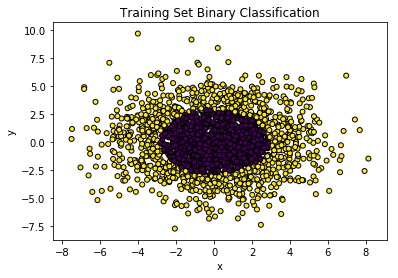

In [7]:
# plot training points
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.xlim(x_min_train, x_max_train)
plt.ylim(y_min_train, y_max_train)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Set Binary Classification')
plt.show()

### Adaboost Functions

In [9]:
# Step 2 (a): Fit a classifier G_m(x) to the training data using the current weight observations
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [8]:
# Step 2 (b): Compute the weighted error rate
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

def print_error_rate(err):
    print 'Error rate: Training: %.4f - Test: %.4f' % err
    
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

In [88]:
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    
    # Step 1: initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    # Iterate through the desired number of classifiers
    for i in range(M):
        
        # Step 2 (a): Fit a classifier, the weak learner, with the current weight values
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        # Indicator function
        miss = [int(x) for x in (pred_train_i != Y_train)]
        # Equivalent with 1/-1 to update weights
        miss2 = [x if x==1 else -1 for x in miss]
        
        # Step 2 (b): Compute the weight error rate on the training sample
        err_m = np.dot(w,miss) / sum(w)
        print('error: {}'.format(err_m))
        
        # Step 2 (c): Calculate the weight given the current classifier
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        print('alpha: {}'.format(alpha_m))
        
        # Step 3 (d): Set the individual weights for each observation to be used in the next iteration
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        print('weights: {}'.format(w))
        
        # Add the prediction to the classifier set
        #pred_train = sum( a * h(x) for (a, h) in zip(alpha_m, )  )
        pred_train = [sum(x) for x in zip(pred_train, [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, [x * alpha_m for x in pred_test_i])]
        #print(pred_train)
        #print(pred_test)
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    print('pred train: {}'.format(pred_train))
    print('pred test: {}'.format(pred_test))
    
    # Return error rate in train and test set
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [89]:
df = pd.DataFrame(X)
df.head()

,0,1
0,0.687486,-0.179089
1,4.273899,-1.864568
2,-1.220894,-0.746466
3,0.719102,-0.885255
4,2.412629,2.624022


In [90]:
df['Y'] = y
df.head()

,0,1,Y
0,0.687486,-0.179089,0
1,4.273899,-1.864568,1
2,-1.220894,-0.746466,0
3,0.719102,-0.885255,0
4,2.412629,2.624022,1


In [91]:
# Split into training and test set
train, test = train_test_split(df, test_size = 0.2)
X_train, Y_train = train.ix[:,:-1], train.ix[:,-1]
X_test, Y_test = test.ix[:,:-1], test.ix[:,-1]

/home/blanca/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/home/blanca/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [92]:
X_train.head()

,0,1
1258,-4.416686,-1.570158
1502,0.604665,0.836229
1093,2.575640,-0.896815
333,1.073468,-1.031473
1629,-2.863359,-4.652715


In [93]:
# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)
er_tree

(0.36375, 0.385)

In [94]:
# Fit Adaboost classifier using a decision tree as base estimator with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 410, 10)
for i in x_range:    
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])

error: 0.36375
alpha: 0.27956237469
weights: [0.00082659 0.00047257 0.00047257 ... 0.00047257 0.00082659 0.00082659]
error: 0.398326683275
alpha: 0.206221076958
weights: [0.00067256 0.0005808  0.0005808  ... 0.0005808  0.00067256 0.00067256]
error: 0.353773647075
alpha: 0.301246270178
weights: [0.00090899 0.00042973 0.00042973 ... 0.00042973 0.00090899 0.00090899]
error: 0.389227377485
alpha: 0.225280529594
weights: [0.00072564 0.00053832 0.00053832 ... 0.00053832 0.00072564 0.00072564]
error: 0.345099839446
alpha: 0.32032451626
weights: [0.00052675 0.00039077 0.00039077 ... 0.00039077 0.00099963 0.00099963]
error: 0.384257503862
alpha: 0.235757969783
weights: [0.00041612 0.00049466 0.00049466 ... 0.00049466 0.00078968 0.00078968]
error: 0.328749717303
alpha: 0.356922671697
weights: [0.00059461 0.00034618 0.00034618 ... 0.00034618 0.00112839 0.00055264]
error: 0.377163527186
alpha: 0.250802574186
weights: [0.00046271 0.00044486 0.00044486 ... 0.00044486 0.00087809 0.00043005]
error: 0.

error: 0.359618636816
alpha: 0.288509875546
weights: [0.00049326 0.00025351 0.00025351 ... 0.00045144 0.00082208 0.0004465 ]
error: 0.409513284113
alpha: 0.182988898199
weights: [0.00041077 0.00030442 0.00030442 ... 0.00054209 0.00068461 0.00037183]
error: 0.357368249254
alpha: 0.293402547311
weights: [0.00030632 0.00022701 0.00022701 ... 0.00040424 0.00091805 0.00049862]
error: 0.397610097014
alpha: 0.207716522836
weights: [0.00037704 0.00018443 0.00027942 ... 0.00032842 0.00112999 0.0004051 ]
error: 0.343658434198
alpha: 0.32351654638
weights: [0.00027283 0.00025488 0.00038615 ... 0.00045387 0.00081766 0.00029313]
error: 0.375739528003
alpha: 0.253835772843
weights: [0.00035166 0.00019774 0.00029959 ... 0.00035212 0.00105394 0.00037783]
error: 0.400473858613
alpha: 0.201745543167
weights: [0.00028741 0.00024195 0.00036655 ... 0.00043084 0.00086139 0.0003088 ]
error: 0.404650469688
alpha: 0.19306251115
weights: [0.00034862 0.00019947 0.0003022  ... 0.0003552  0.00104482 0.00037457]
er

error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
error: 0.371729421946
alpha: 0.262402350597
weights: [0.00045468 0.00027502 0.00027502 ... 0.00027502 0.00075779 0.00041158]
error: 0.397917726426
alpha: 0.207074418321
weights: [0.00036964 0.0003383  0.0003383  ... 0.0003383  0.00061605 0.0003346 ]
error: 0.359618636816
alpha: 0.288509875546
weights: [0.00049326 0.00025351 0.00025351 ... 0.00045144 0.00082208 0.0004465 ]
error: 0.409513284113
alpha: 0.182988898199
weights: [0.00041077 0.00030442 0.00030442 ... 0.00054209 0.00068461 0.00037183]
err

error: 0.419921386129
alpha: 0.161548058818
weights: [0.00029662 0.00023444 0.00035518 ... 0.00041747 0.00088896 0.00031869]
error: 0.404319896995
alpha: 0.193748697083
weights: [0.00036003 0.00019315 0.00029262 ... 0.00034394 0.00107902 0.00026256]
error: 0.419688350742
alpha: 0.16202643587
weights: [0.00030618 0.00022712 0.00034409 ... 0.00040444 0.00091762 0.00022328]
error: 0.400310778503
alpha: 0.202085182579
weights: [0.00025015 0.00018556 0.00028113 ... 0.00033043 0.00112312 0.00027329]
error: 0.416882596915
alpha: 0.167791951796
weights: [0.00021151 0.00021946 0.00033249 ... 0.0003908  0.00094963 0.00023107]
error: 0.401411747948
alpha: 0.199793133076
weights: [0.00025829 0.00017972 0.00027228 ... 0.00032003 0.00115964 0.00028218]
error: 0.417649359377
alpha: 0.166215257144
weights: [0.00021874 0.00021222 0.00032151 ... 0.0003779  0.00098206 0.00023897]
error: 0.417113327983
alpha: 0.167317412607
weights: [0.00025857 0.00017952 0.00027198 ... 0.00031968 0.00116092 0.00028249]
e

error: 0.416882596915
alpha: 0.167791951796
weights: [0.00021151 0.00021946 0.00033249 ... 0.0003908  0.00094963 0.00023107]
error: 0.401411747948
alpha: 0.199793133076
weights: [0.00025829 0.00017972 0.00027228 ... 0.00032003 0.00115964 0.00028218]
error: 0.417649359377
alpha: 0.166215257144
weights: [0.00021874 0.00021222 0.00032151 ... 0.0003779  0.00098206 0.00023897]
error: 0.417113327983
alpha: 0.167317412607
weights: [0.00025857 0.00017952 0.00027198 ... 0.00031968 0.00116092 0.00028249]
error: 0.428899839372
alpha: 0.14317059496
weights: [0.00022408 0.00020715 0.00031384 ... 0.00036888 0.00100606 0.00024481]
error: 0.418269036344
alpha: 0.164941612998
weights: [0.00026427 0.00017565 0.00026612 ... 0.00031279 0.00118647 0.00020758]
error: 0.405913644246
alpha: 0.190442125389
weights: [0.00021844 0.00014519 0.00021997 ... 0.00025855 0.00098073 0.00025113]
error: 0.381257679371
alpha: 0.242106716185
weights: [0.00017147 0.00018497 0.00028023 ... 0.00032938 0.00076985 0.00019713]
e

error: 0.400473858613
alpha: 0.201745543167
weights: [0.00028741 0.00024195 0.00036655 ... 0.00043084 0.00086139 0.0003088 ]
error: 0.404650469688
alpha: 0.19306251115
weights: [0.00034862 0.00019947 0.0003022  ... 0.0003552  0.00104482 0.00037457]
error: 0.419921386129
alpha: 0.161548058818
weights: [0.00029662 0.00023444 0.00035518 ... 0.00041747 0.00088896 0.00031869]
error: 0.404319896995
alpha: 0.193748697083
weights: [0.00036003 0.00019315 0.00029262 ... 0.00034394 0.00107902 0.00026256]
error: 0.419688350742
alpha: 0.16202643587
weights: [0.00030618 0.00022712 0.00034409 ... 0.00040444 0.00091762 0.00022328]
error: 0.400310778503
alpha: 0.202085182579
weights: [0.00025015 0.00018556 0.00028113 ... 0.00033043 0.00112312 0.00027329]
error: 0.416882596915
alpha: 0.167791951796
weights: [0.00021151 0.00021946 0.00033249 ... 0.0003908  0.00094963 0.00023107]
error: 0.401411747948
alpha: 0.199793133076
weights: [0.00025829 0.00017972 0.00027228 ... 0.00032003 0.00115964 0.00028218]
er

error: 0.328749717303
alpha: 0.356922671697
weights: [0.00059461 0.00034618 0.00034618 ... 0.00034618 0.00112839 0.00055264]
error: 0.377163527186
alpha: 0.250802574186
weights: [0.00046271 0.00044486 0.00044486 ... 0.00044486 0.00087809 0.00043005]
error: 0.377251040721
alpha: 0.250616313311
weights: [0.0005945  0.00034624 0.00034624 ... 0.00034624 0.00112818 0.00055253]
error: 0.404742149802
alpha: 0.192872238077
weights: [0.00049021 0.0004199  0.0004199  ... 0.0004199  0.00093028 0.00045561]
error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
err

weights: [9.30183890e-05 5.29105678e-05 2.40260701e-04 ... 2.24431946e-04
 6.56033840e-04 1.24439541e-04]
error: 0.439206520576
alpha: 0.122191485903
weights: [8.23193108e-05 5.97873783e-05 2.71487493e-04 ... 2.53601468e-04
 5.80576101e-04 1.10126367e-04]
error: 0.44195803242
alpha: 0.116609620988
weights: [9.25006193e-05 5.32067332e-05 2.41605554e-04 ... 2.25688198e-04
 6.52382149e-04 9.80050369e-05]
error: 0.447994979811
alpha: 0.104387557103
weights: [8.33315962e-05 5.90611005e-05 2.68189551e-04 ... 2.50520799e-04
 5.87715479e-04 8.82903943e-05]
error: 0.442900283234
alpha: 0.114699799096
weights: [9.34594434e-05 5.26608719e-05 2.39126861e-04 ... 2.23372806e-04
 6.59144479e-04 9.90209175e-05]
error: 0.396326157286
alpha: 0.210398277405
weights: [1.15344795e-04 4.26690756e-05 1.93755283e-04 ... 1.80990379e-04
 5.34079377e-04 1.22208597e-04]
error: 0.417149970951
alpha: 0.167242056748
weights: [9.75810976e-05 5.04365692e-05 2.29026562e-04 ... 2.13937931e-04
 4.51828380e-04 1.03387838e

error: 0.42947931126
alpha: 0.141987930983
weights: [0.00019958 0.00011177 0.00025732 ... 0.00031848 0.00050011 0.00015412]
error: 0.411089469784
alpha: 0.179731696053
weights: [1.66748125e-04 9.33816691e-05 2.14988035e-04 ... 2.66088696e-04
 5.98573951e-04 1.84470449e-04]
error: 0.425640928824
alpha: 0.149829329763
weights: [0.00014355 0.00010848 0.00024974 ... 0.0003091  0.00051529 0.0001588 ]
error: 0.431286955867
alpha: 0.138301165684
weights: [1.64836863e-04 9.44644174e-05 2.17480794e-04 ... 2.69173960e-04
 5.91713114e-04 1.82356054e-04]
error: 0.428416281211
alpha: 0.144157809766
weights: [1.90397518e-04 8.17826745e-05 2.51204752e-04 ... 2.33037655e-04
 6.83467922e-04 1.57874957e-04]
error: 0.394771580116
alpha: 0.213649310428
weights: [0.00015377 0.00010126 0.00031104 ... 0.00028854 0.00055199 0.0001275 ]
error: 0.393623112629
alpha: 0.216053917273
weights: [1.23892079e-04 8.15862556e-05 2.50601429e-04 ... 2.32477965e-04
 6.85113371e-04 1.58255041e-04]
error: 0.401832662247
alph

error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
error: 0.371729421946
alpha: 0.262402350597
weights: [0.00045468 0.00027502 0.00027502 ... 0.00027502 0.00075779 0.00041158]
error: 0.397917726426
alpha: 0.207074418321
weights: [0.00036964 0.0003383  0.0003383  ... 0.0003383  0.00061605 0.0003346 ]
error: 0.359618636816
alpha: 0.288509875546
weights: [0.00049326 0.00025351 0.00025351 ... 0.00045144 0.00082208 0.0004465 ]
error: 0.409513284113
alpha: 0.182988898199
weights: [0.00041077 0.00030442 0.00030442 ... 0.00054209 0.00068461 0.00037183]
error: 0.357368249254
alpha: 0.293402547311
weights: [0.00030632 0.00022701 0.00022701 ... 0.00040424 0.00091805 0.00049862]
er

error: 0.442900283234
alpha: 0.114699799096
weights: [9.34594434e-05 5.26608719e-05 2.39126861e-04 ... 2.23372806e-04
 6.59144479e-04 9.90209175e-05]
error: 0.396326157286
alpha: 0.210398277405
weights: [1.15344795e-04 4.26690756e-05 1.93755283e-04 ... 1.80990379e-04
 5.34079377e-04 1.22208597e-04]
error: 0.417149970951
alpha: 0.167242056748
weights: [9.75810976e-05 5.04365692e-05 2.29026562e-04 ... 2.13937931e-04
 4.51828380e-04 1.03387838e-04]
error: 0.3992682924
alpha: 0.204257410965
weights: [1.19694326e-04 4.11185386e-05 1.86714475e-04 ... 1.74413430e-04
 5.54218951e-04 1.26816955e-04]
error: 0.427437421
alpha: 0.146157071858
weights: [1.03418529e-04 4.75896905e-05 2.16099219e-04 ... 2.01862261e-04
 4.78857355e-04 1.09572636e-04]
error: 0.408610217271
alpha: 0.184856821614
weights: [1.24417266e-04 3.95576590e-05 2.59977340e-04 ... 1.67792613e-04
 5.76087510e-04 9.10793272e-05]
error: 0.435202683635
alpha: 0.130327536364
weights: [1.09214455e-04 4.50641426e-05 2.96166563e-04 ... 1.

weights: [0.00021151 0.00021946 0.00033249 ... 0.0003908  0.00094963 0.00023107]
error: 0.401411747948
alpha: 0.199793133076
weights: [0.00025829 0.00017972 0.00027228 ... 0.00032003 0.00115964 0.00028218]
error: 0.417649359377
alpha: 0.166215257144
weights: [0.00021874 0.00021222 0.00032151 ... 0.0003779  0.00098206 0.00023897]
error: 0.417113327983
alpha: 0.167317412607
weights: [0.00025857 0.00017952 0.00027198 ... 0.00031968 0.00116092 0.00028249]
error: 0.428899839372
alpha: 0.14317059496
weights: [0.00022408 0.00020715 0.00031384 ... 0.00036888 0.00100606 0.00024481]
error: 0.418269036344
alpha: 0.164941612998
weights: [0.00026427 0.00017565 0.00026612 ... 0.00031279 0.00118647 0.00020758]
error: 0.405913644246
alpha: 0.190442125389
weights: [0.00021844 0.00014519 0.00021997 ... 0.00025855 0.00098073 0.00025113]
error: 0.381257679371
alpha: 0.242106716185
weights: [0.00017147 0.00018497 0.00028023 ... 0.00032938 0.00076985 0.00019713]
error: 0.378570037613
alpha: 0.247811058831
w

error: 0.389553829292
alpha: 0.224594030213
weights: [7.33512198e-05 2.23209063e-05 2.16498097e-04 ... 1.32023275e-04
 5.08776781e-04 8.87863773e-05]
error: 0.391250312408
alpha: 0.22102981043
weights: [5.88051434e-05 2.78422194e-05 2.70051199e-04 ... 1.64680633e-04
 4.07882673e-04 7.11793978e-05]
error: 0.448561686653
alpha: 0.10324188399
weights: [6.52007654e-05 2.51111424e-05 2.43561550e-04 ... 1.48526911e-04
 4.52243816e-04 7.89208383e-05]
error: 0.453359866279
alpha: 0.0935522390949
weights: [5.93777139e-05 2.75737410e-05 2.67447135e-04 ... 1.63092642e-04
 4.11854121e-04 7.18724532e-05]
error: 0.448278377828
alpha: 0.103814596446
weights: [6.58733240e-05 2.48547607e-05 2.41074816e-04 ... 1.47010469e-04
 4.56908800e-04 7.97349222e-05]
error: 0.453127066175
alpha: 0.0940219467622
weights: [5.99620354e-05 2.73050388e-05 2.64840901e-04 ... 1.61503328e-04
 4.15907076e-04 7.25797323e-05]
error: 0.45325189518
alpha: 0.0937700811747
weights: [6.58567349e-05 2.48610215e-05 2.41135542e-04 .

error: 0.372429734056
alpha: 0.26090362786
weights: [0.00020863 0.00015202 0.00035    ... 0.00027071 0.00057061 0.00015783]
error: 0.410494648942
alpha: 0.180960451938
weights: [0.00025001 0.00012686 0.00029206 ... 0.0002259  0.0006838  0.00018914]
error: 0.424084360814
alpha: 0.153014395298
weights: [0.00021454 0.00014784 0.00034035 ... 0.00026325 0.00058678 0.00016231]
error: 0.412911987466
alpha: 0.175970139961
weights: [0.00017992 0.00012398 0.00028544 ... 0.00022078 0.00069968 0.00019353]
error: 0.425830530793
alpha: 0.149441571592
weights: [0.00015495 0.00014396 0.00033144 ... 0.00025636 0.00060255 0.00016667]
error: 0.384589052783
alpha: 0.235057441333
weights: [0.000196   0.00011381 0.00026201 ... 0.00032429 0.00076222 0.00021083]
error: 0.391859785967
alpha: 0.21975069181
weights: [2.44173973e-04 9.13558135e-05 2.10324008e-04 ... 2.60316072e-04
 6.11847593e-04 2.62650276e-04]
error: 0.389181322991
alpha: 0.225377394934
weights: [0.0001949  0.00011445 0.00026349 ... 0.00032612 

error: 0.417351275594
alpha: 0.166828109507
weights: [6.49792928e-05 1.80484175e-05 1.75057768e-04 ... 1.49033143e-04
 4.62962008e-04 9.10272397e-05]
error: 0.399714494222
alpha: 0.203327428594
weights: [5.30238185e-05 2.21178602e-05 2.14528684e-04 ... 1.82636191e-04
 3.77782097e-04 7.42792300e-05]
error: 0.452631556016
alpha: 0.0950218477222
weights: [4.82173720e-05 2.01129440e-05 1.95082316e-04 ... 1.66080781e-04
 4.15440504e-04 8.16835976e-05]
error: 0.456730750097
alpha: 0.0867555021132
weights: [4.42105686e-05 2.19357800e-05 2.12762625e-04 ... 1.81132680e-04
 3.80917917e-04 7.48957927e-05]
error: 0.452622626325
alpha: 0.095039868875
weights: [4.86184816e-05 1.99470093e-05 1.93472859e-04 ... 1.64710590e-04
 4.18896461e-04 6.81054914e-05]
error: 0.456723299178
alpha: 0.0867705164105
weights: [4.45776771e-05 2.17551332e-05 2.11010470e-04 ... 1.79641006e-04
 3.84080922e-04 6.24450725e-05]
error: 0.457708010186
alpha: 0.0847865672567
weights: [4.85221206e-05 1.99866224e-05 1.93857080e-

error: 0.378570037613
alpha: 0.247811058831
weights: [0.00021969 0.00014437 0.00021872 ... 0.00025708 0.00060087 0.00025257]
error: 0.39688668921
alpha: 0.209227134246
weights: [0.00027082 0.00011711 0.00026962 ... 0.00020855 0.00074071 0.00020488]
error: 0.372429734056
alpha: 0.26090362786
weights: [0.00020863 0.00015202 0.00035    ... 0.00027071 0.00057061 0.00015783]
error: 0.410494648942
alpha: 0.180960451938
weights: [0.00025001 0.00012686 0.00029206 ... 0.0002259  0.0006838  0.00018914]
error: 0.424084360814
alpha: 0.153014395298
weights: [0.00021454 0.00014784 0.00034035 ... 0.00026325 0.00058678 0.00016231]
error: 0.412911987466
alpha: 0.175970139961
weights: [0.00017992 0.00012398 0.00028544 ... 0.00022078 0.00069968 0.00019353]
error: 0.425830530793
alpha: 0.149441571592
weights: [0.00015495 0.00014396 0.00033144 ... 0.00025636 0.00060255 0.00016667]
error: 0.384589052783
alpha: 0.235057441333
weights: [0.000196   0.00011381 0.00026201 ... 0.00032429 0.00076222 0.00021083]
er

error: 0.45325189518
alpha: 0.0937700811747
weights: [6.58567349e-05 2.48610215e-05 2.41135542e-04 ... 1.47047500e-04
 4.56793734e-04 6.60832713e-05]
error: 0.423888659996
alpha: 0.153415057118
weights: [7.67763582e-05 2.13251285e-05 2.06839707e-04 ... 1.26133467e-04
 3.91825616e-04 7.70404563e-05]
error: 0.417351275594
alpha: 0.166828109507
weights: [6.49792928e-05 1.80484175e-05 1.75057768e-04 ... 1.49033143e-04
 4.62962008e-04 9.10272397e-05]
error: 0.399714494222
alpha: 0.203327428594
weights: [5.30238185e-05 2.21178602e-05 2.14528684e-04 ... 1.82636191e-04
 3.77782097e-04 7.42792300e-05]
error: 0.452631556016
alpha: 0.0950218477222
weights: [4.82173720e-05 2.01129440e-05 1.95082316e-04 ... 1.66080781e-04
 4.15440504e-04 8.16835976e-05]
error: 0.456730750097
alpha: 0.0867555021132
weights: [4.42105686e-05 2.19357800e-05 2.12762625e-04 ... 1.81132680e-04
 3.80917917e-04 7.48957927e-05]
error: 0.452622626325
alpha: 0.095039868875
weights: [4.86184816e-05 1.99470093e-05 1.93472859e-04

error: 0.377251040721
alpha: 0.250616313311
weights: [0.0005945  0.00034624 0.00034624 ... 0.00034624 0.00112818 0.00055253]
error: 0.404742149802
alpha: 0.192872238077
weights: [0.00049021 0.0004199  0.0004199  ... 0.0004199  0.00093028 0.00045561]
error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
error: 0.371729421946
alpha: 0.262402350597
weights: [0.00045468 0.00027502 0.00027502 ... 0.00027502 0.00075779 0.00041158]
error: 0.397917726426
alpha: 0.207074418321
weights: [0.00036964 0.0003383  0.0003383  ... 0.0003383  0.00061605 0.0003346 ]
err

error: 0.439206520576
alpha: 0.122191485903
weights: [8.23193108e-05 5.97873783e-05 2.71487493e-04 ... 2.53601468e-04
 5.80576101e-04 1.10126367e-04]
error: 0.44195803242
alpha: 0.116609620988
weights: [9.25006193e-05 5.32067332e-05 2.41605554e-04 ... 2.25688198e-04
 6.52382149e-04 9.80050369e-05]
error: 0.447994979811
alpha: 0.104387557103
weights: [8.33315962e-05 5.90611005e-05 2.68189551e-04 ... 2.50520799e-04
 5.87715479e-04 8.82903943e-05]
error: 0.442900283234
alpha: 0.114699799096
weights: [9.34594434e-05 5.26608719e-05 2.39126861e-04 ... 2.23372806e-04
 6.59144479e-04 9.90209175e-05]
error: 0.396326157286
alpha: 0.210398277405
weights: [1.15344795e-04 4.26690756e-05 1.93755283e-04 ... 1.80990379e-04
 5.34079377e-04 1.22208597e-04]
error: 0.417149970951
alpha: 0.167242056748
weights: [9.75810976e-05 5.04365692e-05 2.29026562e-04 ... 2.13937931e-04
 4.51828380e-04 1.03387838e-04]
error: 0.3992682924
alpha: 0.204257410965
weights: [1.19694326e-04 4.11185386e-05 1.86714475e-04 ... 

error: 0.462755402132
alpha: 0.0746274274791
weights: [2.94463361e-05 1.10994156e-05 1.95748086e-04 ... 1.14293111e-04
 3.17039641e-04 4.88636638e-05]
error: 0.434213633262
alpha: 0.132339953749
weights: [3.36128840e-05 9.72356680e-06 1.71483766e-04 ... 1.30465165e-04
 3.61899580e-04 5.57776919e-05]
error: 0.432144429698
alpha: 0.136553624188
weights: [2.93225200e-05 1.11462836e-05 1.96574644e-04 ... 1.49554351e-04
 3.15706551e-04 4.86582016e-05]
error: 0.417630529878
alpha: 0.16625396643
weights: [3.46261711e-05 9.43902002e-06 1.66465530e-04 ... 1.26647282e-04
 2.67350139e-04 5.74591549e-05]
error: 0.445955905375
alpha: 0.108512098252
weights: [3.10654941e-05 1.05209053e-05 1.85545542e-04 ... 1.41163390e-04
 2.39858000e-04 5.15505174e-05]
error: 0.41505906184
alpha: 0.171545026967
weights: [3.68790159e-05 8.86241441e-06 2.20268088e-04 ... 1.18910723e-04
 2.84744449e-04 4.34242144e-05]
error: 0.449872438052
alpha: 0.100593055284
weights: [3.33497295e-05 9.80029306e-06 2.43578298e-04 ..

error: 0.428416281211
alpha: 0.144157809766
weights: [1.90397518e-04 8.17826745e-05 2.51204752e-04 ... 2.33037655e-04
 6.83467922e-04 1.57874957e-04]
error: 0.394771580116
alpha: 0.213649310428
weights: [0.00015377 0.00010126 0.00031104 ... 0.00028854 0.00055199 0.0001275 ]
error: 0.393623112629
alpha: 0.216053917273
weights: [1.23892079e-04 8.15862556e-05 2.50601429e-04 ... 2.32477965e-04
 6.85113371e-04 1.58255041e-04]
error: 0.401832662247
alpha: 0.198917402466
weights: [1.51158395e-04 6.68695301e-05 2.05397339e-04 ... 2.83641991e-04
 8.35893934e-04 1.93083998e-04]
error: 0.384657177479
alpha: 0.234913528997
weights: [1.19511755e-04 8.45765412e-05 2.59786430e-04 ... 3.58750219e-04
 6.60890523e-04 1.52659781e-04]
error: 0.42683637997
alpha: 0.147385235516
weights: [1.38490256e-04 7.29862963e-05 2.24185680e-04 ... 3.09587616e-04
 7.65840129e-04 1.76902198e-04]
error: 0.436175624662
alpha: 0.128348920331
weights: [1.21808611e-04 8.29817432e-05 2.54887827e-04 ... 3.51985528e-04
 6.73591

error: 0.460059537923
alpha: 0.0800514833452
weights: [4.43223918e-05 1.85215222e-05 2.34700719e-04 ... 1.52939761e-04
 4.51136334e-04 5.61419844e-05]
error: 0.458845509285
alpha: 0.0824956154236
weights: [4.08127442e-05 1.70549043e-05 2.16116054e-04 ... 1.40829299e-04
 4.89931312e-04 6.09698532e-05]
error: 0.42171638712
alpha: 0.157865704195
weights: [4.77920877e-05 1.45642821e-05 1.84555429e-04 ... 1.20263216e-04
 4.18383927e-04 7.13962421e-05]
error: 0.412689229676
alpha: 0.176429630937
weights: [4.00620886e-05 1.73744672e-05 2.20165487e-04 ... 1.43468061e-04
 3.50713576e-04 5.98484543e-05]
error: 0.452877478202
alpha: 0.0945255723234
weights: [4.40337347e-05 1.58073679e-05 2.00307544e-04 ... 1.30527883e-04
 3.85482362e-04 6.57816667e-05]
error: 0.445032279937
alpha: 0.110381565644
weights: [4.91726514e-05 1.41553775e-05 1.79373880e-04 ... 1.45761020e-04
 4.30469728e-04 7.34586560e-05]
error: 0.423039205226
alpha: 0.155154729517
weights: [4.21056895e-05 1.65311970e-05 2.09479749e-04

error: 0.389227377485
alpha: 0.225280529594
weights: [0.00072564 0.00053832 0.00053832 ... 0.00053832 0.00072564 0.00072564]
error: 0.345099839446
alpha: 0.32032451626
weights: [0.00052675 0.00039077 0.00039077 ... 0.00039077 0.00099963 0.00099963]
error: 0.384257503862
alpha: 0.235757969783
weights: [0.00041612 0.00049466 0.00049466 ... 0.00049466 0.00078968 0.00078968]
error: 0.328749717303
alpha: 0.356922671697
weights: [0.00059461 0.00034618 0.00034618 ... 0.00034618 0.00112839 0.00055264]
error: 0.377163527186
alpha: 0.250802574186
weights: [0.00046271 0.00044486 0.00044486 ... 0.00044486 0.00087809 0.00043005]
error: 0.377251040721
alpha: 0.250616313311
weights: [0.0005945  0.00034624 0.00034624 ... 0.00034624 0.00112818 0.00055253]
error: 0.404742149802
alpha: 0.192872238077
weights: [0.00049021 0.0004199  0.0004199  ... 0.0004199  0.00093028 0.00045561]
error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
er

error: 0.438408578188
alpha: 0.123811637782
weights: [7.94301719e-05 6.19620437e-05 2.81362394e-04 ... 2.62825795e-04
 5.60199776e-04 1.06261291e-04]
error: 0.431496474236
alpha: 0.13787408775
weights: [9.11724148e-05 5.39818517e-05 2.45125276e-04 ... 2.28976036e-04
 6.43014678e-04 1.21970006e-04]
error: 0.439751010627
alpha: 0.121086313496
weights: [8.07748835e-05 6.09305216e-05 2.76678373e-04 ... 2.58450365e-04
 5.69683667e-04 1.08060239e-04]
error: 0.42989923731
alpha: 0.141131136231
weights: [9.30183890e-05 5.29105678e-05 2.40260701e-04 ... 2.24431946e-04
 6.56033840e-04 1.24439541e-04]
error: 0.439206520576
alpha: 0.122191485903
weights: [8.23193108e-05 5.97873783e-05 2.71487493e-04 ... 2.53601468e-04
 5.80576101e-04 1.10126367e-04]
error: 0.44195803242
alpha: 0.116609620988
weights: [9.25006193e-05 5.32067332e-05 2.41605554e-04 ... 2.25688198e-04
 6.52382149e-04 9.80050369e-05]
error: 0.447994979811
alpha: 0.104387557103
weights: [8.33315962e-05 5.90611005e-05 2.68189551e-04 ... 

weights: [3.70548574e-05 1.22713632e-05 2.16416426e-04 ... 1.26360912e-04
 3.98958250e-04 4.41970551e-05]
error: 0.41819053811
alpha: 0.165102923798
weights: [3.14153468e-05 1.04037407e-05 1.83479239e-04 ... 1.07129595e-04
 3.38239374e-04 5.21310678e-05]
error: 0.427933649261
alpha: 0.145143411987
weights: [2.71710784e-05 1.20288609e-05 2.12139682e-04 ... 1.23863813e-04
 2.92542641e-04 4.50880692e-05]
error: 0.460601097134
alpha: 0.0789615036806
weights: [2.94035265e-05 1.11155756e-05 1.96033082e-04 ... 1.14459515e-04
 3.16578724e-04 4.87926250e-05]
error: 0.463478881162
alpha: 0.073172552631
weights: [2.73288266e-05 1.19594276e-05 2.10915164e-04 ... 1.23148843e-04
 2.94241068e-04 4.53498388e-05]
error: 0.462755402132
alpha: 0.0746274274791
weights: [2.94463361e-05 1.10994156e-05 1.95748086e-04 ... 1.14293111e-04
 3.17039641e-04 4.88636638e-05]
error: 0.434213633262
alpha: 0.132339953749
weights: [3.36128840e-05 9.72356680e-06 1.71483766e-04 ... 1.30465165e-04
 3.61899580e-04 5.5777691

error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
error: 0.371729421946
alpha: 0.262402350597
weights: [0.00045468 0.00027502 0.00027502 ... 0.00027502 0.00075779 0.00041158]
error: 0.397917726426
alpha: 0.207074418321
weights: [0.00036964 0.0003383  0.0003383  ... 0.0003383  0.00061605 0.0003346 ]
error: 0.359618636816
alpha: 0.288509875546
weights: [0.00049326 0.00025351 0.00025351 ... 0.00045144 0.00082208 0.0004465 ]
error: 0.409513284113
alpha: 0.182988898199
weights: [0.00041077 0.00030442 0.00030442 ... 0.00054209 0.00068461 0.00037183]
error: 0.357368249254
alpha: 0.293402547311
weights: [0.00030632 0.00022701 0.00022701 ... 0.00040424 0.00091805 0.00049862]
er

error: 0.442900283234
alpha: 0.114699799096
weights: [9.34594434e-05 5.26608719e-05 2.39126861e-04 ... 2.23372806e-04
 6.59144479e-04 9.90209175e-05]
error: 0.396326157286
alpha: 0.210398277405
weights: [1.15344795e-04 4.26690756e-05 1.93755283e-04 ... 1.80990379e-04
 5.34079377e-04 1.22208597e-04]
error: 0.417149970951
alpha: 0.167242056748
weights: [9.75810976e-05 5.04365692e-05 2.29026562e-04 ... 2.13937931e-04
 4.51828380e-04 1.03387838e-04]
error: 0.3992682924
alpha: 0.204257410965
weights: [1.19694326e-04 4.11185386e-05 1.86714475e-04 ... 1.74413430e-04
 5.54218951e-04 1.26816955e-04]
error: 0.427437421
alpha: 0.146157071858
weights: [1.03418529e-04 4.75896905e-05 2.16099219e-04 ... 2.01862261e-04
 4.78857355e-04 1.09572636e-04]
error: 0.408610217271
alpha: 0.184856821614
weights: [1.24417266e-04 3.95576590e-05 2.59977340e-04 ... 1.67792613e-04
 5.76087510e-04 9.10793272e-05]
error: 0.435202683635
alpha: 0.130327536364
weights: [1.09214455e-04 4.50641426e-05 2.96166563e-04 ... 1.

error: 0.432144429698
alpha: 0.136553624188
weights: [2.93225200e-05 1.11462836e-05 1.96574644e-04 ... 1.49554351e-04
 3.15706551e-04 4.86582016e-05]
error: 0.417630529878
alpha: 0.16625396643
weights: [3.46261711e-05 9.43902002e-06 1.66465530e-04 ... 1.26647282e-04
 2.67350139e-04 5.74591549e-05]
error: 0.445955905375
alpha: 0.108512098252
weights: [3.10654941e-05 1.05209053e-05 1.85545542e-04 ... 1.41163390e-04
 2.39858000e-04 5.15505174e-05]
error: 0.41505906184
alpha: 0.171545026967
weights: [3.68790159e-05 8.86241441e-06 2.20268088e-04 ... 1.18910723e-04
 2.84744449e-04 4.34242144e-05]
error: 0.449872438052
alpha: 0.100593055284
weights: [3.33497295e-05 9.80029306e-06 2.43578298e-04 ... 1.31494633e-04
 2.57494679e-04 3.92685587e-05]
error: 0.462942035409
alpha: 0.0742520887224
weights: [3.09631433e-05 9.09896073e-06 2.26147254e-04 ... 1.22084564e-04
 2.77341928e-04 4.22953120e-05]
error: 0.465499101555
alpha: 0.0691116223599
weights: [2.88955022e-05 9.75004425e-06 2.42329404e-04 .

error: 0.377163527186
alpha: 0.250802574186
weights: [0.00046271 0.00044486 0.00044486 ... 0.00044486 0.00087809 0.00043005]
error: 0.377251040721
alpha: 0.250616313311
weights: [0.0005945  0.00034624 0.00034624 ... 0.00034624 0.00112818 0.00055253]
error: 0.404742149802
alpha: 0.192872238077
weights: [0.00049021 0.0004199  0.0004199  ... 0.0004199  0.00093028 0.00045561]
error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
error: 0.371729421946
alpha: 0.262402350597
weights: [0.00045468 0.00027502 0.00027502 ... 0.00027502 0.00075779 0.00041158]
err

error: 0.442900283234
alpha: 0.114699799096
weights: [9.34594434e-05 5.26608719e-05 2.39126861e-04 ... 2.23372806e-04
 6.59144479e-04 9.90209175e-05]
error: 0.396326157286
alpha: 0.210398277405
weights: [1.15344795e-04 4.26690756e-05 1.93755283e-04 ... 1.80990379e-04
 5.34079377e-04 1.22208597e-04]
error: 0.417149970951
alpha: 0.167242056748
weights: [9.75810976e-05 5.04365692e-05 2.29026562e-04 ... 2.13937931e-04
 4.51828380e-04 1.03387838e-04]
error: 0.3992682924
alpha: 0.204257410965
weights: [1.19694326e-04 4.11185386e-05 1.86714475e-04 ... 1.74413430e-04
 5.54218951e-04 1.26816955e-04]
error: 0.427437421
alpha: 0.146157071858
weights: [1.03418529e-04 4.75896905e-05 2.16099219e-04 ... 2.01862261e-04
 4.78857355e-04 1.09572636e-04]
error: 0.408610217271
alpha: 0.184856821614
weights: [1.24417266e-04 3.95576590e-05 2.59977340e-04 ... 1.67792613e-04
 5.76087510e-04 9.10793272e-05]
error: 0.435202683635
alpha: 0.130327536364
weights: [1.09214455e-04 4.50641426e-05 2.96166563e-04 ... 1.

error: 0.445955905375
alpha: 0.108512098252
weights: [3.10654941e-05 1.05209053e-05 1.85545542e-04 ... 1.41163390e-04
 2.39858000e-04 5.15505174e-05]
error: 0.41505906184
alpha: 0.171545026967
weights: [3.68790159e-05 8.86241441e-06 2.20268088e-04 ... 1.18910723e-04
 2.84744449e-04 4.34242144e-05]
error: 0.449872438052
alpha: 0.100593055284
weights: [3.33497295e-05 9.80029306e-06 2.43578298e-04 ... 1.31494633e-04
 2.57494679e-04 3.92685587e-05]
error: 0.462942035409
alpha: 0.0742520887224
weights: [3.09631433e-05 9.09896073e-06 2.26147254e-04 ... 1.22084564e-04
 2.77341928e-04 4.22953120e-05]
error: 0.465499101555
alpha: 0.0691116223599
weights: [2.88955022e-05 9.75004425e-06 2.42329404e-04 ... 1.30820424e-04
 2.58821729e-04 3.94709371e-05]
error: 0.465897097576
alpha: 0.068311866238
weights: [3.09383902e-05 9.10624059e-06 2.26328189e-04 ... 1.22182241e-04
 2.77120211e-04 4.22614996e-05]
error: 0.468074595486
alpha: 0.0639377935759
weights: [2.90221700e-05 9.70748998e-06 2.41271753e-04

error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
error: 0.371729421946
alpha: 0.262402350597
weights: [0.00045468 0.00027502 0.00027502 ... 0.00027502 0.00075779 0.00041158]
error: 0.397917726426
alpha: 0.207074418321
weights: [0.00036964 0.0003383  0.0003383  ... 0.0003383  0.00061605 0.0003346 ]
error: 0.359618636816
alpha: 0.288509875546
weights: [0.00049326 0.00025351 0.00025351 ... 0.00045144 0.00082208 0.0004465 ]
error: 0.409513284113
alpha: 0.182988898199
weights: [0.00041077 0.00030442 0.00030442 ... 0.00054209 0.00068461 0.00037183]
error: 0.357368249254
alpha: 0.293402547311
weights: [0.00030632 0.00022701 0.00022701 ... 0.00040424 0.00091805 0.00049862]
error: 0.397610097014
alpha: 0.207716522836
weights: [0.00037704 0.00018443 0.00027942 ... 0.00032842 0.00112999 0.0004051 ]
error: 0.343658434198
alpha: 0.32351654638
weights: [0.00027283 0.00025488 0.00038615 ... 0.00045387 0.00081766 0.00029313]
e

error: 0.417149970951
alpha: 0.167242056748
weights: [9.75810976e-05 5.04365692e-05 2.29026562e-04 ... 2.13937931e-04
 4.51828380e-04 1.03387838e-04]
error: 0.3992682924
alpha: 0.204257410965
weights: [1.19694326e-04 4.11185386e-05 1.86714475e-04 ... 1.74413430e-04
 5.54218951e-04 1.26816955e-04]
error: 0.427437421
alpha: 0.146157071858
weights: [1.03418529e-04 4.75896905e-05 2.16099219e-04 ... 2.01862261e-04
 4.78857355e-04 1.09572636e-04]
error: 0.408610217271
alpha: 0.184856821614
weights: [1.24417266e-04 3.95576590e-05 2.59977340e-04 ... 1.67792613e-04
 5.76087510e-04 9.10793272e-05]
error: 0.435202683635
alpha: 0.130327536364
weights: [1.09214455e-04 4.50641426e-05 2.96166563e-04 ... 1.91149588e-04
 5.05694150e-04 7.99501502e-05]
error: 0.437857351358
alpha: 0.124931232696
weights: [9.63880465e-05 3.97717012e-05 2.61384049e-04 ... 1.68700520e-04
 5.72987140e-04 9.05891592e-05]
error: 0.444726975625
alpha: 0.110999686322
weights: [8.62614248e-05 4.44406824e-05 2.92069113e-04 ... 1.

weights: [3.10654941e-05 1.05209053e-05 1.85545542e-04 ... 1.41163390e-04
 2.39858000e-04 5.15505174e-05]
error: 0.41505906184
alpha: 0.171545026967
weights: [3.68790159e-05 8.86241441e-06 2.20268088e-04 ... 1.18910723e-04
 2.84744449e-04 4.34242144e-05]
error: 0.449872438052
alpha: 0.100593055284
weights: [3.33497295e-05 9.80029306e-06 2.43578298e-04 ... 1.31494633e-04
 2.57494679e-04 3.92685587e-05]
error: 0.462942035409
alpha: 0.0742520887224
weights: [3.09631433e-05 9.09896073e-06 2.26147254e-04 ... 1.22084564e-04
 2.77341928e-04 4.22953120e-05]
error: 0.465499101555
alpha: 0.0691116223599
weights: [2.88955022e-05 9.75004425e-06 2.42329404e-04 ... 1.30820424e-04
 2.58821729e-04 3.94709371e-05]
error: 0.465897097576
alpha: 0.068311866238
weights: [3.09383902e-05 9.10624059e-06 2.26328189e-04 ... 1.22182241e-04
 2.77120211e-04 4.22614996e-05]
error: 0.468074595486
alpha: 0.0639377935759
weights: [2.90221700e-05 9.70748998e-06 2.41271753e-04 ... 1.30249455e-04
 2.59956314e-04 3.964396

error: 0.377163527186
alpha: 0.250802574186
weights: [0.00046271 0.00044486 0.00044486 ... 0.00044486 0.00087809 0.00043005]
error: 0.377251040721
alpha: 0.250616313311
weights: [0.0005945  0.00034624 0.00034624 ... 0.00034624 0.00112818 0.00055253]
error: 0.404742149802
alpha: 0.192872238077
weights: [0.00049021 0.0004199  0.0004199  ... 0.0004199  0.00093028 0.00045561]
error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
error: 0.371729421946
alpha: 0.262402350597
weights: [0.00045468 0.00027502 0.00027502 ... 0.00027502 0.00075779 0.00041158]
err

error: 0.42989923731
alpha: 0.141131136231
weights: [9.30183890e-05 5.29105678e-05 2.40260701e-04 ... 2.24431946e-04
 6.56033840e-04 1.24439541e-04]
error: 0.439206520576
alpha: 0.122191485903
weights: [8.23193108e-05 5.97873783e-05 2.71487493e-04 ... 2.53601468e-04
 5.80576101e-04 1.10126367e-04]
error: 0.44195803242
alpha: 0.116609620988
weights: [9.25006193e-05 5.32067332e-05 2.41605554e-04 ... 2.25688198e-04
 6.52382149e-04 9.80050369e-05]
error: 0.447994979811
alpha: 0.104387557103
weights: [8.33315962e-05 5.90611005e-05 2.68189551e-04 ... 2.50520799e-04
 5.87715479e-04 8.82903943e-05]
error: 0.442900283234
alpha: 0.114699799096
weights: [9.34594434e-05 5.26608719e-05 2.39126861e-04 ... 2.23372806e-04
 6.59144479e-04 9.90209175e-05]
error: 0.396326157286
alpha: 0.210398277405
weights: [1.15344795e-04 4.26690756e-05 1.93755283e-04 ... 1.80990379e-04
 5.34079377e-04 1.22208597e-04]
error: 0.417149970951
alpha: 0.167242056748
weights: [9.75810976e-05 5.04365692e-05 2.29026562e-04 ...

error: 0.463478881162
alpha: 0.073172552631
weights: [2.73288266e-05 1.19594276e-05 2.10915164e-04 ... 1.23148843e-04
 2.94241068e-04 4.53498388e-05]
error: 0.462755402132
alpha: 0.0746274274791
weights: [2.94463361e-05 1.10994156e-05 1.95748086e-04 ... 1.14293111e-04
 3.17039641e-04 4.88636638e-05]
error: 0.434213633262
alpha: 0.132339953749
weights: [3.36128840e-05 9.72356680e-06 1.71483766e-04 ... 1.30465165e-04
 3.61899580e-04 5.57776919e-05]
error: 0.432144429698
alpha: 0.136553624188
weights: [2.93225200e-05 1.11462836e-05 1.96574644e-04 ... 1.49554351e-04
 3.15706551e-04 4.86582016e-05]
error: 0.417630529878
alpha: 0.16625396643
weights: [3.46261711e-05 9.43902002e-06 1.66465530e-04 ... 1.26647282e-04
 2.67350139e-04 5.74591549e-05]
error: 0.445955905375
alpha: 0.108512098252
weights: [3.10654941e-05 1.05209053e-05 1.85545542e-04 ... 1.41163390e-04
 2.39858000e-04 5.15505174e-05]
error: 0.41505906184
alpha: 0.171545026967
weights: [3.68790159e-05 8.86241441e-06 2.20268088e-04 ..

error: 0.473674542283
alpha: 0.0526996480469
weights: [1.29017094e-05 3.19308894e-06 1.50458179e-04 ... 9.00995657e-05
 1.98559642e-04 2.77403552e-05]
error: 0.472693129079
alpha: 0.0546681373103
weights: [1.36266571e-05 3.02321439e-06 1.42453699e-04 ... 8.53062060e-05
 2.09716717e-04 2.92990870e-05]
error: 0.474107230128
alpha: 0.0518319061932
weights: [1.29383536e-05 3.18404544e-06 1.50032049e-04 ... 8.98443845e-05
 1.99123602e-04 2.78191449e-05]
error: 0.47466707426
alpha: 0.0507092719375
weights: [1.36113679e-05 3.02661026e-06 1.42613712e-04 ... 8.54020275e-05
 2.09481414e-04 2.92662133e-05]
error: 0.475888694104
alpha: 0.0482600433125
weights: [1.29700814e-05 3.17625652e-06 1.49665036e-04 ... 8.96246044e-05
 1.99611899e-04 2.78873639e-05]
error: 0.474725869326
alpha: 0.050591379875
weights: [1.36431376e-05 3.01956243e-06 1.42281619e-04 ... 8.52031585e-05
 2.09970356e-04 2.65115980e-05]
error: 0.461295895165
alpha: 0.0775633787153
weights: [1.47434665e-05 2.79420757e-06 1.31662910e

error: 0.384657177479
alpha: 0.234913528997
weights: [1.19511755e-04 8.45765412e-05 2.59786430e-04 ... 3.58750219e-04
 6.60890523e-04 1.52659781e-04]
error: 0.42683637997
alpha: 0.147385235516
weights: [1.38490256e-04 7.29862963e-05 2.24185680e-04 ... 3.09587616e-04
 7.65840129e-04 1.76902198e-04]
error: 0.436175624662
alpha: 0.128348920331
weights: [1.21808611e-04 8.29817432e-05 2.54887827e-04 ... 3.51985528e-04
 6.73591954e-04 1.55593697e-04]
error: 0.429834334935
alpha: 0.141263546104
weights: [1.40290405e-04 7.20497661e-05 2.21309021e-04 ... 3.05615115e-04
 7.75794810e-04 1.35095854e-04]
error: 0.438469054378
alpha: 0.12368882365
weights: [1.23968285e-04 8.15361027e-05 2.50447379e-04 ... 3.45853522e-04
 6.85534785e-04 1.19378096e-04]
error: 0.434167769524
alpha: 0.132433298276
weights: [1.41522550e-04 7.14224754e-05 2.19382227e-04 ... 3.02954322e-04
 7.82608475e-04 1.36282377e-04]
error: 0.44182707618
alpha: 0.116875119262
weights: [1.25912088e-04 8.02773666e-05 2.46581028e-04 ... 

error: 0.452877478202
alpha: 0.0945255723234
weights: [4.40337347e-05 1.58073679e-05 2.00307544e-04 ... 1.30527883e-04
 3.85482362e-04 6.57816667e-05]
error: 0.445032279937
alpha: 0.110381565644
weights: [4.91726514e-05 1.41553775e-05 1.79373880e-04 ... 1.45761020e-04
 4.30469728e-04 7.34586560e-05]
error: 0.423039205226
alpha: 0.155154729517
weights: [4.21056895e-05 1.65311970e-05 2.09479749e-04 ... 1.70225352e-04
 3.68603771e-04 6.29013744e-05]
error: 0.457339367524
alpha: 0.085529212245
weights: [4.58654489e-05 1.51760740e-05 1.92307924e-04 ... 1.56271355e-04
 4.01517648e-04 5.77451176e-05]
error: 0.460693083372
alpha: 0.0787763844637
weights: [4.23909841e-05 1.64199407e-05 2.08069934e-04 ... 1.69079722e-04
 3.71101312e-04 5.33707273e-05]
error: 0.448454298532
alpha: 0.103458962504
weights: [3.82245026e-05 1.48060744e-05 1.87619370e-04 ... 1.52461388e-04
 4.11551459e-04 5.91881516e-05]
error: 0.454611637863
alpha: 0.0910273103245
weights: [3.48986947e-05 1.62170773e-05 2.05499292e-0

error: 0.423943820909
alpha: 0.153302120243
weights: [2.49500283e-05 4.19456039e-06 1.55033733e-04 ... 7.95947324e-05
 2.45214275e-04 3.37271102e-05]
error: 0.402089301898
alpha: 0.198383600274
weights: [2.04604009e-05 3.43977114e-06 1.27136222e-04 ... 9.70602107e-05
 2.99021663e-04 4.11278526e-05]
error: 0.436657467364
alpha: 0.127369394519
weights: [1.80135087e-05 3.90701765e-06 1.44405963e-04 ... 1.10244531e-04
 2.63261182e-04 3.62093066e-05]
error: 0.456752733785
alpha: 0.0867112031541
weights: [1.65173403e-05 3.58250806e-06 1.32411873e-04 ... 1.01087826e-04
 2.87107822e-04 3.94892064e-05]
error: 0.439586052161
alpha: 0.121421104841
weights: [1.86497336e-05 3.17288740e-06 1.49506283e-04 ... 8.95295378e-05
 3.24173522e-04 3.49740471e-05]
error: 0.4313715139
alpha: 0.138128798304
weights: [1.62436663e-05 3.64286633e-06 1.71651665e-04 ... 1.02790959e-04
 2.82350763e-04 3.04619229e-05]
error: 0.471059337782
alpha: 0.0579460936067
weights: [1.53291611e-05 3.43777593e-06 1.61987817e-04 .

error: 0.416882596915
alpha: 0.167791951796
weights: [0.00021151 0.00021946 0.00033249 ... 0.0003908  0.00094963 0.00023107]
error: 0.401411747948
alpha: 0.199793133076
weights: [0.00025829 0.00017972 0.00027228 ... 0.00032003 0.00115964 0.00028218]
error: 0.417649359377
alpha: 0.166215257144
weights: [0.00021874 0.00021222 0.00032151 ... 0.0003779  0.00098206 0.00023897]
error: 0.417113327983
alpha: 0.167317412607
weights: [0.00025857 0.00017952 0.00027198 ... 0.00031968 0.00116092 0.00028249]
error: 0.428899839372
alpha: 0.14317059496
weights: [0.00022408 0.00020715 0.00031384 ... 0.00036888 0.00100606 0.00024481]
error: 0.418269036344
alpha: 0.164941612998
weights: [0.00026427 0.00017565 0.00026612 ... 0.00031279 0.00118647 0.00020758]
error: 0.405913644246
alpha: 0.190442125389
weights: [0.00021844 0.00014519 0.00021997 ... 0.00025855 0.00098073 0.00025113]
error: 0.381257679371
alpha: 0.242106716185
weights: [0.00017147 0.00018497 0.00028023 ... 0.00032938 0.00076985 0.00019713]
e

error: 0.403904392433
alpha: 0.194611436009
weights: [9.18221142e-05 2.79416322e-05 2.71015438e-04 ... 1.65268639e-04
 6.36894108e-04 7.09261503e-05]
error: 0.389553829292
alpha: 0.224594030213
weights: [7.33512198e-05 2.23209063e-05 2.16498097e-04 ... 1.32023275e-04
 5.08776781e-04 8.87863773e-05]
error: 0.391250312408
alpha: 0.22102981043
weights: [5.88051434e-05 2.78422194e-05 2.70051199e-04 ... 1.64680633e-04
 4.07882673e-04 7.11793978e-05]
error: 0.448561686653
alpha: 0.10324188399
weights: [6.52007654e-05 2.51111424e-05 2.43561550e-04 ... 1.48526911e-04
 4.52243816e-04 7.89208383e-05]
error: 0.453359866279
alpha: 0.0935522390949
weights: [5.93777139e-05 2.75737410e-05 2.67447135e-04 ... 1.63092642e-04
 4.11854121e-04 7.18724532e-05]
error: 0.448278377828
alpha: 0.103814596446
weights: [6.58733240e-05 2.48547607e-05 2.41074816e-04 ... 1.47010469e-04
 4.56908800e-04 7.97349222e-05]
error: 0.453127066175
alpha: 0.0940219467622
weights: [5.99620354e-05 2.73050388e-05 2.64840901e-04 .

error: 0.471328837225
alpha: 0.0574052997461
weights: [2.44190786e-05 9.00052796e-06 2.23700788e-04 ... 1.20763850e-04
 2.80375032e-04 3.35835836e-05]
error: 0.472883746274
alpha: 0.0542857703919
weights: [2.31288086e-05 9.50263386e-06 2.36180221e-04 ... 1.27500815e-04
 2.65560407e-04 3.18090740e-05]
error: 0.472036042703
alpha: 0.0559863371753
weights: [2.44606402e-05 8.98523497e-06 2.23320693e-04 ... 1.20558658e-04
 2.80852234e-04 3.36407434e-05]
error: 0.473517172044
alpha: 0.0530152687054
weights: [2.31976280e-05 9.47444278e-06 2.35479554e-04 ... 1.27122564e-04
 2.66350578e-04 3.19037215e-05]
error: 0.47214333374
alpha: 0.0557710843863
weights: [2.45281422e-05 8.96050740e-06 2.22706109e-04 ... 1.20226878e-04
 2.81627278e-04 3.37335789e-05]
error: 0.43009202261
alpha: 0.140737856378
weights: [2.82349049e-05 7.78414520e-06 1.93468586e-04 ... 1.04443134e-04
 2.44654407e-04 3.88314934e-05]
error: 0.414205789328
alpha: 0.173302812789
weights: [3.35776876e-05 6.54555495e-06 1.62684434e-0

error: 0.423716173242
alpha: 0.153768232884
weights: [1.10079049e-05 1.72415807e-06 1.44213138e-04 ... 7.77554956e-05
 2.15705403e-04 2.37241441e-05]
error: 0.443291744527
alpha: 0.113906602786
weights: [9.82280812e-06 1.93217336e-06 1.61612086e-04 ... 8.71364982e-05
 1.92482839e-04 2.11700335e-05]
error: 0.430560246801
alpha: 0.139782864081
weights: [1.12964657e-05 1.68011559e-06 1.85857787e-04 ... 7.57692827e-05
 2.21359896e-04 1.84083396e-05]
error: 0.451591076068
alpha: 0.0971220744229
weights: [1.02509238e-05 1.85147880e-06 2.04814332e-04 ... 8.34973625e-05
 2.00871980e-04 1.67045599e-05]
error: 0.461569339961
alpha: 0.0770132157642
weights: [9.49110093e-06 1.71424278e-06 1.89633005e-04 ... 7.73083390e-05
 2.16953057e-04 1.80418660e-05]
pred train: [1. 1. 1. ... 1. 1. 1.]
pred test: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

error: 0.429834334935
alpha: 0.141263546104
weights: [1.40290405e-04 7.20497661e-05 2.21309021e-04 ... 3.05615115e-04
 7.75794810e-04 1.35095854e-04]
error: 0.438469054378
alpha: 0.12368882365
weights: [1.23968285e-04 8.15361027e-05 2.50447379e-04 ... 3.45853522e-04
 6.85534785e-04 1.19378096e-04]
error: 0.434167769524
alpha: 0.132433298276
weights: [1.41522550e-04 7.14224754e-05 2.19382227e-04 ... 3.02954322e-04
 7.82608475e-04 1.36282377e-04]
error: 0.44182707618
alpha: 0.116875119262
weights: [1.25912088e-04 8.02773666e-05 2.46581028e-04 ... 3.40514313e-04
 6.96283859e-04 1.21249925e-04]
error: 0.439487640894
alpha: 0.121620848258
weights: [1.11493144e-04 7.10843267e-05 2.18343565e-04 ... 3.01519989e-04
 7.86331350e-04 1.36930673e-04]
error: 0.446020495246
alpha: 0.108381393301
weights: [1.00041161e-04 7.92215427e-05 2.43337946e-04 ... 3.36035801e-04
 7.05563571e-04 1.22865882e-04]
error: 0.438090144815
alpha: 0.12445836886
weights: [1.13300103e-04 6.99506433e-05 2.14861327e-04 ... 

error: 0.457339367524
alpha: 0.085529212245
weights: [4.58654489e-05 1.51760740e-05 1.92307924e-04 ... 1.56271355e-04
 4.01517648e-04 5.77451176e-05]
error: 0.460693083372
alpha: 0.0787763844637
weights: [4.23909841e-05 1.64199407e-05 2.08069934e-04 ... 1.69079722e-04
 3.71101312e-04 5.33707273e-05]
error: 0.448454298532
alpha: 0.103458962504
weights: [3.82245026e-05 1.48060744e-05 1.87619370e-04 ... 1.52461388e-04
 4.11551459e-04 5.91881516e-05]
error: 0.454611637863
alpha: 0.0910273103245
weights: [3.48986947e-05 1.62170773e-05 2.05499292e-04 ... 1.66990793e-04
 3.75743509e-04 5.40383549e-05]
error: 0.462750629065
alpha: 0.0746370268818
weights: [3.76030985e-05 1.50507498e-05 1.90719844e-04 ... 1.54980865e-04
 4.04860993e-04 5.01519322e-05]
error: 0.445505703735
alpha: 0.109423235323
weights: [3.37055738e-05 1.34907542e-05 1.70951917e-04 ... 1.38917248e-04
 3.62897544e-04 5.59512222e-05]
error: 0.418104774809
alpha: 0.165279173763
weights: [3.97632212e-05 1.14355326e-05 2.01675809e-0

error: 0.402089301898
alpha: 0.198383600274
weights: [2.04604009e-05 3.43977114e-06 1.27136222e-04 ... 9.70602107e-05
 2.99021663e-04 4.11278526e-05]
error: 0.436657467364
alpha: 0.127369394519
weights: [1.80135087e-05 3.90701765e-06 1.44405963e-04 ... 1.10244531e-04
 2.63261182e-04 3.62093066e-05]
error: 0.456752733785
alpha: 0.0867112031541
weights: [1.65173403e-05 3.58250806e-06 1.32411873e-04 ... 1.01087826e-04
 2.87107822e-04 3.94892064e-05]
error: 0.439586052161
alpha: 0.121421104841
weights: [1.86497336e-05 3.17288740e-06 1.49506283e-04 ... 8.95295378e-05
 3.24173522e-04 3.49740471e-05]
error: 0.4313715139
alpha: 0.138128798304
weights: [1.62436663e-05 3.64286633e-06 1.71651665e-04 ... 1.02790959e-04
 2.82350763e-04 3.04619229e-05]
error: 0.471059337782
alpha: 0.0579460936067
weights: [1.53291611e-05 3.43777593e-06 1.61987817e-04 ... 9.70039119e-05
 2.99195208e-04 3.22792164e-05]
error: 0.440875520775
alpha: 0.118804780278
weights: [1.72629356e-05 3.05268018e-06 1.43842125e-04 .

weights: [0.00049021 0.0004199  0.0004199  ... 0.0004199  0.00093028 0.00045561]
error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
error: 0.371729421946
alpha: 0.262402350597
weights: [0.00045468 0.00027502 0.00027502 ... 0.00027502 0.00075779 0.00041158]
error: 0.397917726426
alpha: 0.207074418321
weights: [0.00036964 0.0003383  0.0003383  ... 0.0003383  0.00061605 0.0003346 ]
error: 0.359618636816
alpha: 0.288509875546
weights: [0.00049326 0.00025351 0.00025351 ... 0.00045144 0.00082208 0.0004465 ]
error: 0.409513284113
alpha: 0.182988898199
wei

error: 0.447994979811
alpha: 0.104387557103
weights: [8.33315962e-05 5.90611005e-05 2.68189551e-04 ... 2.50520799e-04
 5.87715479e-04 8.82903943e-05]
error: 0.442900283234
alpha: 0.114699799096
weights: [9.34594434e-05 5.26608719e-05 2.39126861e-04 ... 2.23372806e-04
 6.59144479e-04 9.90209175e-05]
error: 0.396326157286
alpha: 0.210398277405
weights: [1.15344795e-04 4.26690756e-05 1.93755283e-04 ... 1.80990379e-04
 5.34079377e-04 1.22208597e-04]
error: 0.417149970951
alpha: 0.167242056748
weights: [9.75810976e-05 5.04365692e-05 2.29026562e-04 ... 2.13937931e-04
 4.51828380e-04 1.03387838e-04]
error: 0.3992682924
alpha: 0.204257410965
weights: [1.19694326e-04 4.11185386e-05 1.86714475e-04 ... 1.74413430e-04
 5.54218951e-04 1.26816955e-04]
error: 0.427437421
alpha: 0.146157071858
weights: [1.03418529e-04 4.75896905e-05 2.16099219e-04 ... 2.01862261e-04
 4.78857355e-04 1.09572636e-04]
error: 0.408610217271
alpha: 0.184856821614
weights: [1.24417266e-04 3.95576590e-05 2.59977340e-04 ... 1.

error: 0.434213633262
alpha: 0.132339953749
weights: [3.36128840e-05 9.72356680e-06 1.71483766e-04 ... 1.30465165e-04
 3.61899580e-04 5.57776919e-05]
error: 0.432144429698
alpha: 0.136553624188
weights: [2.93225200e-05 1.11462836e-05 1.96574644e-04 ... 1.49554351e-04
 3.15706551e-04 4.86582016e-05]
error: 0.417630529878
alpha: 0.16625396643
weights: [3.46261711e-05 9.43902002e-06 1.66465530e-04 ... 1.26647282e-04
 2.67350139e-04 5.74591549e-05]
error: 0.445955905375
alpha: 0.108512098252
weights: [3.10654941e-05 1.05209053e-05 1.85545542e-04 ... 1.41163390e-04
 2.39858000e-04 5.15505174e-05]
error: 0.41505906184
alpha: 0.171545026967
weights: [3.68790159e-05 8.86241441e-06 2.20268088e-04 ... 1.18910723e-04
 2.84744449e-04 4.34242144e-05]
error: 0.449872438052
alpha: 0.100593055284
weights: [3.33497295e-05 9.80029306e-06 2.43578298e-04 ... 1.31494633e-04
 2.57494679e-04 3.92685587e-05]
error: 0.462942035409
alpha: 0.0742520887224
weights: [3.09631433e-05 9.09896073e-06 2.26147254e-04 ..

error: 0.475888694104
alpha: 0.0482600433125
weights: [1.29700814e-05 3.17625652e-06 1.49665036e-04 ... 8.96246044e-05
 1.99611899e-04 2.78873639e-05]
error: 0.474725869326
alpha: 0.050591379875
weights: [1.36431376e-05 3.01956243e-06 1.42281619e-04 ... 8.52031585e-05
 2.09970356e-04 2.65115980e-05]
error: 0.461295895165
alpha: 0.0775633787153
weights: [1.47434665e-05 2.79420757e-06 1.31662910e-04 ... 7.88443082e-05
 2.26904616e-04 2.86497775e-05]
error: 0.433810601991
alpha: 0.13316030489
weights: [1.68434245e-05 2.44583908e-06 1.50416070e-04 ... 6.90143753e-05
 2.59223349e-04 2.50778597e-05]
error: 0.432117132756
alpha: 0.136609242841
weights: [1.46927048e-05 2.80386126e-06 1.72433990e-04 ... 7.91167068e-05
 2.26123384e-04 2.18756934e-05]
error: 0.472088134969
alpha: 0.0558818263507
weights: [1.38941692e-05 2.65147387e-06 1.63062354e-04 ... 7.48167835e-05
 2.39119308e-04 2.31329488e-05]
error: 0.473563896855
alpha: 0.0529215566509
weights: [1.31779861e-05 2.79557335e-06 1.71924293e-0

error: 0.389227377485
alpha: 0.225280529594
weights: [0.00072564 0.00053832 0.00053832 ... 0.00053832 0.00072564 0.00072564]
error: 0.345099839446
alpha: 0.32032451626
weights: [0.00052675 0.00039077 0.00039077 ... 0.00039077 0.00099963 0.00099963]
error: 0.384257503862
alpha: 0.235757969783
weights: [0.00041612 0.00049466 0.00049466 ... 0.00049466 0.00078968 0.00078968]
error: 0.328749717303
alpha: 0.356922671697
weights: [0.00059461 0.00034618 0.00034618 ... 0.00034618 0.00112839 0.00055264]
error: 0.377163527186
alpha: 0.250802574186
weights: [0.00046271 0.00044486 0.00044486 ... 0.00044486 0.00087809 0.00043005]
error: 0.377251040721
alpha: 0.250616313311
weights: [0.0005945  0.00034624 0.00034624 ... 0.00034624 0.00112818 0.00055253]
error: 0.404742149802
alpha: 0.192872238077
weights: [0.00049021 0.0004199  0.0004199  ... 0.0004199  0.00093028 0.00045561]
error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
er

error: 0.38309555816
alpha: 0.238214839639
weights: [8.98992800e-05 5.47463314e-05 2.48596689e-04 ... 2.32218746e-04
 6.34035598e-04 1.20266812e-04]
error: 0.438408578188
alpha: 0.123811637782
weights: [7.94301719e-05 6.19620437e-05 2.81362394e-04 ... 2.62825795e-04
 5.60199776e-04 1.06261291e-04]
error: 0.431496474236
alpha: 0.13787408775
weights: [9.11724148e-05 5.39818517e-05 2.45125276e-04 ... 2.28976036e-04
 6.43014678e-04 1.21970006e-04]
error: 0.439751010627
alpha: 0.121086313496
weights: [8.07748835e-05 6.09305216e-05 2.76678373e-04 ... 2.58450365e-04
 5.69683667e-04 1.08060239e-04]
error: 0.42989923731
alpha: 0.141131136231
weights: [9.30183890e-05 5.29105678e-05 2.40260701e-04 ... 2.24431946e-04
 6.56033840e-04 1.24439541e-04]
error: 0.439206520576
alpha: 0.122191485903
weights: [8.23193108e-05 5.97873783e-05 2.71487493e-04 ... 2.53601468e-04
 5.80576101e-04 1.10126367e-04]
error: 0.44195803242
alpha: 0.116609620988
weights: [9.25006193e-05 5.32067332e-05 2.41605554e-04 ... 2

weights: [3.63253695e-05 1.25177973e-05 2.20762512e-04 ... 1.28898498e-04
 3.91104077e-04 4.33269608e-05]
error: 0.462142868051
alpha: 0.075859444708
weights: [3.36716735e-05 1.35043366e-05 2.38161011e-04 ... 1.39057109e-04
 3.62532550e-04 4.01617740e-05]
error: 0.452274482164
alpha: 0.0957425123284
weights: [3.70548574e-05 1.22713632e-05 2.16416426e-04 ... 1.26360912e-04
 3.98958250e-04 4.41970551e-05]
error: 0.41819053811
alpha: 0.165102923798
weights: [3.14153468e-05 1.04037407e-05 1.83479239e-04 ... 1.07129595e-04
 3.38239374e-04 5.21310678e-05]
error: 0.427933649261
alpha: 0.145143411987
weights: [2.71710784e-05 1.20288609e-05 2.12139682e-04 ... 1.23863813e-04
 2.92542641e-04 4.50880692e-05]
error: 0.460601097134
alpha: 0.0789615036806
weights: [2.94035265e-05 1.11155756e-05 1.96033082e-04 ... 1.14459515e-04
 3.16578724e-04 4.87926250e-05]
error: 0.463478881162
alpha: 0.073172552631
weights: [2.73288266e-05 1.19594276e-05 2.10915164e-04 ... 1.23148843e-04
 2.94241068e-04 4.5349838

error: 0.443334941464
alpha: 0.113819083989
weights: [1.28188391e-05 3.21373140e-06 1.51430850e-04 ... 9.06820351e-05
 1.97284252e-04 3.08061133e-05]
error: 0.46954575056
alpha: 0.0609839873505
weights: [1.36249120e-05 3.02360160e-06 1.42471945e-04 ... 8.53171322e-05
 2.09689860e-04 3.27432601e-05]
error: 0.471294179024
alpha: 0.0574748450991
weights: [1.28639012e-05 3.20247372e-06 1.50900389e-04 ... 9.03643766e-05
 1.97977767e-04 3.09144062e-05]
error: 0.47221144967
alpha: 0.0556344293885
weights: [1.35998595e-05 3.02917141e-06 1.42734394e-04 ... 8.54742957e-05
 2.09304298e-04 2.92414688e-05]
error: 0.473674542283
alpha: 0.0526996480469
weights: [1.29017094e-05 3.19308894e-06 1.50458179e-04 ... 9.00995657e-05
 1.98559642e-04 2.77403552e-05]
error: 0.472693129079
alpha: 0.0546681373103
weights: [1.36266571e-05 3.02321439e-06 1.42453699e-04 ... 8.53062060e-05
 2.09716717e-04 2.92990870e-05]
error: 0.474107230128
alpha: 0.0518319061932
weights: [1.29383536e-05 3.18404544e-06 1.50032049e-

pred train: [1. 1. 1. ... 1. 1. 1.]
pred test: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 

error: 0.438090144815
alpha: 0.12445836886
weights: [1.13300103e-04 6.99506433e-05 2.14861327e-04 ... 2.96711218e-04
 7.99075348e-04 1.39149896e-04]
error: 0.403496194284
alpha: 0.195459282846
weights: [1.37758115e-04 5.75313844e-05 2.61243289e-04 ... 2.44032168e-04
 9.71571173e-04 1.14444782e-04]
error: 0.40680501291
alpha: 0.18859458636
weights: [1.14080549e-04 6.94720977e-05 3.15464672e-04 ... 2.94681361e-04
 8.04579628e-04 9.47742614e-05]
error: 0.38309555816
alpha: 0.238214839639
weights: [8.98992800e-05 5.47463314e-05 2.48596689e-04 ... 2.32218746e-04
 6.34035598e-04 1.20266812e-04]
error: 0.438408578188
alpha: 0.123811637782
weights: [7.94301719e-05 6.19620437e-05 2.81362394e-04 ... 2.62825795e-04
 5.60199776e-04 1.06261291e-04]
error: 0.431496474236
alpha: 0.13787408775
weights: [9.11724148e-05 5.39818517e-05 2.45125276e-04 ... 2.28976036e-04
 6.43014678e-04 1.21970006e-04]
error: 0.439751010627
alpha: 0.121086313496
weights: [8.07748835e-05 6.09305216e-05 2.76678373e-04 ... 2.

error: 0.418104774809
alpha: 0.165279173763
weights: [3.97632212e-05 1.14355326e-05 2.01675809e-04 ... 1.17754182e-04
 4.28118369e-04 4.74274467e-05]
error: 0.414582569857
alpha: 0.17252649516
weights: [3.34621818e-05 1.35888812e-05 2.39652030e-04 ... 1.39927683e-04
 3.60277016e-04 3.99119034e-05]
error: 0.459041743835
alpha: 0.0821004821316
weights: [3.63253695e-05 1.25177973e-05 2.20762512e-04 ... 1.28898498e-04
 3.91104077e-04 4.33269608e-05]
error: 0.462142868051
alpha: 0.075859444708
weights: [3.36716735e-05 1.35043366e-05 2.38161011e-04 ... 1.39057109e-04
 3.62532550e-04 4.01617740e-05]
error: 0.452274482164
alpha: 0.0957425123284
weights: [3.70548574e-05 1.22713632e-05 2.16416426e-04 ... 1.26360912e-04
 3.98958250e-04 4.41970551e-05]
error: 0.41819053811
alpha: 0.165102923798
weights: [3.14153468e-05 1.04037407e-05 1.83479239e-04 ... 1.07129595e-04
 3.38239374e-04 5.21310678e-05]
error: 0.427933649261
alpha: 0.145143411987
weights: [2.71710784e-05 1.20288609e-05 2.12139682e-04 .

error: 0.440875520775
alpha: 0.118804780278
weights: [1.72629356e-05 3.05268018e-06 1.43842125e-04 ... 8.61376438e-05
 2.65679701e-04 3.63512412e-05]
error: 0.441389958838
alpha: 0.117761441905
weights: [1.53451630e-05 3.43419104e-06 1.61818897e-04 ... 9.69027568e-05
 2.36164833e-04 3.23129122e-05]
error: 0.471505295215
alpha: 0.0570512266735
weights: [1.62460782e-05 3.24375032e-06 1.52845340e-04 ... 9.15290805e-05
 2.50030081e-04 3.05210217e-05]
error: 0.438750873967
alpha: 0.123116557575
weights: [1.43641422e-05 2.86799623e-06 1.35139828e-04 ... 8.09264068e-05
 2.21066747e-04 3.45197712e-05]
error: 0.443334941464
alpha: 0.113819083989
weights: [1.28188391e-05 3.21373140e-06 1.51430850e-04 ... 9.06820351e-05
 1.97284252e-04 3.08061133e-05]
error: 0.46954575056
alpha: 0.0609839873505
weights: [1.36249120e-05 3.02360160e-06 1.42471945e-04 ... 8.53171322e-05
 2.09689860e-04 3.27432601e-05]
error: 0.471294179024
alpha: 0.0574748450991
weights: [1.28639012e-05 3.20247372e-06 1.50900389e-04

error: 0.480327899163
alpha: 0.0393645217152
weights: [7.29848369e-06 1.37182520e-06 1.99680480e-04 ... 7.70035736e-05
 1.98969822e-04 1.44287286e-05]
error: 0.480251184685
alpha: 0.0395181894726
weights: [7.59268134e-06 1.31867036e-06 1.91943355e-04 ... 7.40198753e-05
 2.06990180e-04 1.50103423e-05]
error: 0.481001577365
alpha: 0.0380151472391
weights: [7.30946186e-06 1.36976483e-06 1.99380577e-04 ... 7.68879210e-05
 1.99269107e-04 1.44504319e-05]
error: 0.480520749352
alpha: 0.0389782292113
weights: [7.59999724e-06 1.31740098e-06 1.91758586e-04 ... 7.39486224e-05
 2.07189625e-04 1.50248054e-05]
error: 0.481251175458
alpha: 0.0375152387458
weights: [7.32016336e-06 1.36776235e-06 1.99089099e-04 ... 7.67755169e-05
 1.99560849e-04 1.44715882e-05]
error: 0.480737003906
alpha: 0.0385450699419
weights: [7.60782798e-06 1.31604498e-06 1.91561209e-04 ... 7.38725070e-05
 2.07403105e-04 1.39243934e-05]
error: 0.481451599441
alpha: 0.0371138323841
weights: [7.33064776e-06 1.36580615e-06 1.9880435

weights: [0.00014355 0.00010848 0.00024974 ... 0.0003091  0.00051529 0.0001588 ]
error: 0.431286955867
alpha: 0.138301165684
weights: [1.64836863e-04 9.44644174e-05 2.17480794e-04 ... 2.69173960e-04
 5.91713114e-04 1.82356054e-04]
error: 0.428416281211
alpha: 0.144157809766
weights: [1.90397518e-04 8.17826745e-05 2.51204752e-04 ... 2.33037655e-04
 6.83467922e-04 1.57874957e-04]
error: 0.394771580116
alpha: 0.213649310428
weights: [0.00015377 0.00010126 0.00031104 ... 0.00028854 0.00055199 0.0001275 ]
error: 0.393623112629
alpha: 0.216053917273
weights: [1.23892079e-04 8.15862556e-05 2.50601429e-04 ... 2.32477965e-04
 6.85113371e-04 1.58255041e-04]
error: 0.401832662247
alpha: 0.198917402466
weights: [1.51158395e-04 6.68695301e-05 2.05397339e-04 ... 2.83641991e-04
 8.35893934e-04 1.93083998e-04]
error: 0.384657177479
alpha: 0.234913528997
weights: [1.19511755e-04 8.45765412e-05 2.59786430e-04 ... 3.58750219e-04
 6.60890523e-04 1.52659781e-04]
error: 0.42683637997
alpha: 0.147385235516
w

error: 0.425837592602
alpha: 0.149427130232
weights: [4.09126180e-05 2.00651585e-05 2.54261344e-04 ... 1.65686196e-04
 4.16429884e-04 5.18229154e-05]
error: 0.460059537923
alpha: 0.0800514833452
weights: [4.43223918e-05 1.85215222e-05 2.34700719e-04 ... 1.52939761e-04
 4.51136334e-04 5.61419844e-05]
error: 0.458845509285
alpha: 0.0824956154236
weights: [4.08127442e-05 1.70549043e-05 2.16116054e-04 ... 1.40829299e-04
 4.89931312e-04 6.09698532e-05]
error: 0.42171638712
alpha: 0.157865704195
weights: [4.77920877e-05 1.45642821e-05 1.84555429e-04 ... 1.20263216e-04
 4.18383927e-04 7.13962421e-05]
error: 0.412689229676
alpha: 0.176429630937
weights: [4.00620886e-05 1.73744672e-05 2.20165487e-04 ... 1.43468061e-04
 3.50713576e-04 5.98484543e-05]
error: 0.452877478202
alpha: 0.0945255723234
weights: [4.40337347e-05 1.58073679e-05 2.00307544e-04 ... 1.30527883e-04
 3.85482362e-04 6.57816667e-05]
error: 0.445032279937
alpha: 0.110381565644
weights: [4.91726514e-05 1.41553775e-05 1.79373880e-04

error: 0.47133648939
alpha: 0.0573899449413
weights: [2.12659560e-05 4.92121775e-06 1.81891471e-04 ... 9.33835668e-05
 2.83998567e-04 3.21067867e-05]
error: 0.472890591052
alpha: 0.0542720404642
weights: [2.01425692e-05 5.19568281e-06 1.92035881e-04 ... 9.85917341e-05
 2.68996173e-04 3.04107264e-05]
error: 0.471368141319
alpha: 0.0573264325869
weights: [2.13310099e-05 4.90620936e-06 1.81336751e-04 ... 9.30987719e-05
 2.84867336e-04 3.22050033e-05]
error: 0.472918905463
alpha: 0.0542152448562
weights: [2.02053341e-05 5.17954318e-06 1.91439350e-04 ... 9.82854734e-05
 2.69834373e-04 3.05054873e-05]
error: 0.472394867122
alpha: 0.0552664653969
weights: [2.13534453e-05 4.90105456e-06 1.81146226e-04 ... 9.30009560e-05
 2.85166952e-04 2.88652980e-05]
error: 0.473839211223
alpha: 0.0523694003964
weights: [2.02639551e-05 5.16455942e-06 1.90885541e-04 ... 9.80011461e-05
 2.70617235e-04 2.73925399e-05]
error: 0.472662719883
alpha: 0.0547291378495
weights: [2.14038933e-05 4.88950299e-06 1.80719272

error: 0.478108862108
alpha: 0.043810283238
weights: [8.54661945e-06 1.38892518e-06 2.02169524e-04 ... 7.79634336e-05
 1.96520171e-04 1.69230910e-05]
error: 0.477455323461
alpha: 0.045119946706
weights: [8.94107445e-06 1.32764972e-06 1.93250375e-04 ... 7.45239068e-05
 2.05590232e-04 1.77041481e-05]
error: 0.478427991374
alpha: 0.0431708167029
weights: [8.56329417e-06 1.38622062e-06 2.01775853e-04 ... 7.78116207e-05
 1.96903588e-04 1.69561085e-05]
error: 0.477730256409
alpha: 0.0445689742594
weights: [8.95358422e-06 1.32579475e-06 1.92980369e-04 ... 7.44197834e-05
 2.05877881e-04 1.62169855e-05]
error: 0.478679845172
alpha: 0.0426661806991
weights: [8.57960386e-06 1.38358544e-06 2.01392281e-04 ... 7.76637021e-05
 1.97278612e-04 1.55396217e-05]
error: 0.477939252928
alpha: 0.0441501581616
weights: [8.20905312e-06 1.32382876e-06 1.92694203e-04 ... 7.43094280e-05
 2.06183626e-04 1.62410690e-05]
error: 0.478871475019
alpha: 0.0422822291613
weights: [7.86919174e-06 1.38100341e-06 2.01016445e

error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
error: 0.371729421946
alpha: 0.262402350597
weights: [0.00045468 0.00027502 0.00027502 ... 0.00027502 0.00075779 0.00041158]
error: 0.397917726426
alpha: 0.207074418321
weights: [0.00036964 0.0003383  0.0003383  ... 0.0003383  0.00061605 0.0003346 ]
error: 0.359618636816
alpha: 0.288509875546
weights: [0.00049326 0.00025351 0.00025351 ... 0.00045144 0.00082208 0.0004465 ]
error: 0.409513284113
alpha: 0.182988898199
weights: [0.00041077 0.00030442 0.00030442 ... 0.00054209 0.00068461 0.00037183]
err

error: 0.447994979811
alpha: 0.104387557103
weights: [8.33315962e-05 5.90611005e-05 2.68189551e-04 ... 2.50520799e-04
 5.87715479e-04 8.82903943e-05]
error: 0.442900283234
alpha: 0.114699799096
weights: [9.34594434e-05 5.26608719e-05 2.39126861e-04 ... 2.23372806e-04
 6.59144479e-04 9.90209175e-05]
error: 0.396326157286
alpha: 0.210398277405
weights: [1.15344795e-04 4.26690756e-05 1.93755283e-04 ... 1.80990379e-04
 5.34079377e-04 1.22208597e-04]
error: 0.417149970951
alpha: 0.167242056748
weights: [9.75810976e-05 5.04365692e-05 2.29026562e-04 ... 2.13937931e-04
 4.51828380e-04 1.03387838e-04]
error: 0.3992682924
alpha: 0.204257410965
weights: [1.19694326e-04 4.11185386e-05 1.86714475e-04 ... 1.74413430e-04
 5.54218951e-04 1.26816955e-04]
error: 0.427437421
alpha: 0.146157071858
weights: [1.03418529e-04 4.75896905e-05 2.16099219e-04 ... 2.01862261e-04
 4.78857355e-04 1.09572636e-04]
error: 0.408610217271
alpha: 0.184856821614
weights: [1.24417266e-04 3.95576590e-05 2.59977340e-04 ... 1.

error: 0.463478881162
alpha: 0.073172552631
weights: [2.73288266e-05 1.19594276e-05 2.10915164e-04 ... 1.23148843e-04
 2.94241068e-04 4.53498388e-05]
error: 0.462755402132
alpha: 0.0746274274791
weights: [2.94463361e-05 1.10994156e-05 1.95748086e-04 ... 1.14293111e-04
 3.17039641e-04 4.88636638e-05]
error: 0.434213633262
alpha: 0.132339953749
weights: [3.36128840e-05 9.72356680e-06 1.71483766e-04 ... 1.30465165e-04
 3.61899580e-04 5.57776919e-05]
error: 0.432144429698
alpha: 0.136553624188
weights: [2.93225200e-05 1.11462836e-05 1.96574644e-04 ... 1.49554351e-04
 3.15706551e-04 4.86582016e-05]
error: 0.417630529878
alpha: 0.16625396643
weights: [3.46261711e-05 9.43902002e-06 1.66465530e-04 ... 1.26647282e-04
 2.67350139e-04 5.74591549e-05]
error: 0.445955905375
alpha: 0.108512098252
weights: [3.10654941e-05 1.05209053e-05 1.85545542e-04 ... 1.41163390e-04
 2.39858000e-04 5.15505174e-05]
error: 0.41505906184
alpha: 0.171545026967
weights: [3.68790159e-05 8.86241441e-06 2.20268088e-04 ..

error: 0.471294179024
alpha: 0.0574748450991
weights: [1.28639012e-05 3.20247372e-06 1.50900389e-04 ... 9.03643766e-05
 1.97977767e-04 3.09144062e-05]
error: 0.47221144967
alpha: 0.0556344293885
weights: [1.35998595e-05 3.02917141e-06 1.42734394e-04 ... 8.54742957e-05
 2.09304298e-04 2.92414688e-05]
error: 0.473674542283
alpha: 0.0526996480469
weights: [1.29017094e-05 3.19308894e-06 1.50458179e-04 ... 9.00995657e-05
 1.98559642e-04 2.77403552e-05]
error: 0.472693129079
alpha: 0.0546681373103
weights: [1.36266571e-05 3.02321439e-06 1.42453699e-04 ... 8.53062060e-05
 2.09716717e-04 2.92990870e-05]
error: 0.474107230128
alpha: 0.0518319061932
weights: [1.29383536e-05 3.18404544e-06 1.50032049e-04 ... 8.98443845e-05
 1.99123602e-04 2.78191449e-05]
error: 0.47466707426
alpha: 0.0507092719375
weights: [1.36113679e-05 3.02661026e-06 1.42613712e-04 ... 8.54020275e-05
 2.09481414e-04 2.92662133e-05]
error: 0.475888694104
alpha: 0.0482600433125
weights: [1.29700814e-05 3.17625652e-06 1.49665036e

error: 0.481451599441
alpha: 0.0371138323841
weights: [7.33064776e-06 1.36580615e-06 1.98804359e-04 ... 7.66657115e-05
 1.99846672e-04 1.34170782e-05]
error: 0.480905447253
alpha: 0.0382076868515
weights: [7.05584390e-06 1.31460620e-06 1.91351784e-04 ... 7.37917454e-05
 2.07630098e-04 1.39396330e-05]
error: 0.481607827856
alpha: 0.036800948589
weights: [6.80090198e-06 1.36388617e-06 1.98524890e-04 ... 7.65579387e-05
 2.00128002e-04 1.34359658e-05]
error: 0.481538957393
alpha: 0.0369388768435
weights: [7.05681717e-06 1.31442490e-06 1.91325393e-04 ... 7.37815682e-05
 2.07658738e-04 1.39415558e-05]
error: 0.482196306868
alpha: 0.0356224464244
weights: [6.80986079e-06 1.36209189e-06 1.98263717e-04 ... 7.64572218e-05
 2.00391630e-04 1.34536650e-05]
error: 0.481778091142
alpha: 0.0364599648934
weights: [7.06272986e-06 1.31332450e-06 1.91165221e-04 ... 7.37198006e-05
 2.07832729e-04 1.39532370e-05]
error: 0.482418816586
alpha: 0.0351768690788
weights: [6.81860410e-06 1.36034532e-06 1.98009489

error: 0.39688668921
alpha: 0.209227134246
weights: [0.00027082 0.00011711 0.00026962 ... 0.00020855 0.00074071 0.00020488]
error: 0.372429734056
alpha: 0.26090362786
weights: [0.00020863 0.00015202 0.00035    ... 0.00027071 0.00057061 0.00015783]
error: 0.410494648942
alpha: 0.180960451938
weights: [0.00025001 0.00012686 0.00029206 ... 0.0002259  0.0006838  0.00018914]
error: 0.424084360814
alpha: 0.153014395298
weights: [0.00021454 0.00014784 0.00034035 ... 0.00026325 0.00058678 0.00016231]
error: 0.412911987466
alpha: 0.175970139961
weights: [0.00017992 0.00012398 0.00028544 ... 0.00022078 0.00069968 0.00019353]
error: 0.425830530793
alpha: 0.149441571592
weights: [0.00015495 0.00014396 0.00033144 ... 0.00025636 0.00060255 0.00016667]
error: 0.384589052783
alpha: 0.235057441333
weights: [0.000196   0.00011381 0.00026201 ... 0.00032429 0.00076222 0.00021083]
error: 0.391859785967
alpha: 0.21975069181
weights: [2.44173973e-04 9.13558135e-05 2.10324008e-04 ... 2.60316072e-04
 6.1184759

error: 0.423888659996
alpha: 0.153415057118
weights: [7.67763582e-05 2.13251285e-05 2.06839707e-04 ... 1.26133467e-04
 3.91825616e-04 7.70404563e-05]
error: 0.417351275594
alpha: 0.166828109507
weights: [6.49792928e-05 1.80484175e-05 1.75057768e-04 ... 1.49033143e-04
 4.62962008e-04 9.10272397e-05]
error: 0.399714494222
alpha: 0.203327428594
weights: [5.30238185e-05 2.21178602e-05 2.14528684e-04 ... 1.82636191e-04
 3.77782097e-04 7.42792300e-05]
error: 0.452631556016
alpha: 0.0950218477222
weights: [4.82173720e-05 2.01129440e-05 1.95082316e-04 ... 1.66080781e-04
 4.15440504e-04 8.16835976e-05]
error: 0.456730750097
alpha: 0.0867555021132
weights: [4.42105686e-05 2.19357800e-05 2.12762625e-04 ... 1.81132680e-04
 3.80917917e-04 7.48957927e-05]
error: 0.452622626325
alpha: 0.095039868875
weights: [4.86184816e-05 1.99470093e-05 1.93472859e-04 ... 1.64710590e-04
 4.18896461e-04 6.81054914e-05]
error: 0.456723299178
alpha: 0.0867705164105
weights: [4.45776771e-05 2.17551332e-05 2.11010470e-0

error: 0.419329581844
alpha: 0.162763063574
weights: [2.85340675e-05 7.70253311e-06 1.91440183e-04 ... 1.46160981e-04
 2.47246640e-04 3.92429321e-05]
error: 0.421213422047
alpha: 0.158897079545
weights: [2.43419608e-05 6.57090894e-06 1.63314587e-04 ... 1.24687617e-04
 2.89826788e-04 4.60012437e-05]
error: 0.402074676866
alpha: 0.198414016867
weights: [2.96842221e-05 5.38834428e-06 1.99156777e-04 ... 1.02247621e-04
 3.53434252e-04 3.77224126e-05]
error: 0.423258652971
alpha: 0.15470521452
weights: [2.54295135e-05 4.61602035e-06 1.70611173e-04 ... 8.75922316e-05
 3.02775699e-04 4.40338929e-05]
error: 0.414900178745
alpha: 0.171872254573
weights: [2.14138561e-05 5.48164475e-06 2.02605225e-04 ... 1.04018063e-04
 2.54963401e-04 3.70803573e-05]
error: 0.457412579171
alpha: 0.085381717069
weights: [2.33225315e-05 5.03303648e-06 1.86024365e-04 ... 9.55054058e-05
 2.77688984e-04 4.03854307e-05]
error: 0.461604142709
alpha: 0.0769431969967
weights: [2.15953219e-05 5.43558241e-06 2.00902730e-04 .

error: 0.445497582917
alpha: 0.109439672234
weights: [1.23600918e-05 1.31633741e-06 1.45615908e-04 ... 7.38889218e-05
 2.07357029e-04 2.34956009e-05]
error: 0.431709006269
alpha: 0.137440917883
weights: [1.07728810e-05 1.51027856e-06 1.67070071e-04 ... 8.47752661e-05
 1.80729451e-04 2.04784331e-05]
error: 0.445309946821
alpha: 0.10981947279
weights: [9.65245694e-06 1.35320335e-06 1.49694094e-04 ... 7.59582885e-05
 2.01707906e-04 2.28554994e-05]
error: 0.457179896466
alpha: 0.0858505020154
weights: [8.85836301e-06 1.47450913e-06 1.63113184e-04 ... 8.27674490e-05
 1.85113683e-04 2.09752099e-05]
error: 0.431813193551
alpha: 0.137228588428
weights: [1.01613426e-05 1.28543419e-06 1.87105556e-04 ... 7.21542557e-05
 2.12342116e-04 1.82855782e-05]
error: 0.458085053519
alpha: 0.0840270952829
weights: [9.34240281e-06 1.39811324e-06 2.03506922e-04 ... 7.84791797e-05
 1.95228688e-04 1.68118766e-05]
error: 0.47491951862
alpha: 0.0502030967582
weights: [9.82339294e-06 1.32965638e-06 1.93542461e-04 

error: 0.458803395788
alpha: 0.0825804175194
weights: [5.43255145e-06 6.75252540e-07 1.77542382e-04 ... 4.72013060e-05
 1.56461805e-04 1.30622623e-05]
error: 0.439260777119
alpha: 0.12208134603
weights: [6.13794656e-06 5.97650065e-07 1.57138566e-04 ... 5.33302071e-05
 1.76777746e-04 1.47583449e-05]
error: 0.462595369338
alpha: 0.0749492866309
weights: [5.69472873e-06 6.44164865e-07 1.69368581e-04 ... 5.74808699e-05
 1.64012720e-04 1.36926527e-05]
error: 0.453484632259
alpha: 0.0933005227524
weights: [6.25162535e-06 5.86782470e-07 1.54281178e-04 ... 5.23604572e-05
 1.80051785e-04 1.50316791e-05]
error: 0.453476132218
alpha: 0.0933176712772
weights: [6.86309946e-06 5.34502549e-07 1.69371485e-04 ... 4.76953544e-05
 1.97662727e-04 1.36924179e-05]
pred train: [1. 1. 1. ... 1. 1. 1.]
pred test: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

error: 0.438469054378
alpha: 0.12368882365
weights: [1.23968285e-04 8.15361027e-05 2.50447379e-04 ... 3.45853522e-04
 6.85534785e-04 1.19378096e-04]
error: 0.434167769524
alpha: 0.132433298276
weights: [1.41522550e-04 7.14224754e-05 2.19382227e-04 ... 3.02954322e-04
 7.82608475e-04 1.36282377e-04]
error: 0.44182707618
alpha: 0.116875119262
weights: [1.25912088e-04 8.02773666e-05 2.46581028e-04 ... 3.40514313e-04
 6.96283859e-04 1.21249925e-04]
error: 0.439487640894
alpha: 0.121620848258
weights: [1.11493144e-04 7.10843267e-05 2.18343565e-04 ... 3.01519989e-04
 7.86331350e-04 1.36930673e-04]
error: 0.446020495246
alpha: 0.108381393301
weights: [1.00041161e-04 7.92215427e-05 2.43337946e-04 ... 3.36035801e-04
 7.05563571e-04 1.22865882e-04]
error: 0.438090144815
alpha: 0.12445836886
weights: [1.13300103e-04 6.99506433e-05 2.14861327e-04 ... 2.96711218e-04
 7.99075348e-04 1.39149896e-04]
error: 0.403496194284
alpha: 0.195459282846
weights: [1.37758115e-04 5.75313844e-05 2.61243289e-04 ... 

 4.01517648e-04 5.77451176e-05]
error: 0.460693083372
alpha: 0.0787763844637
weights: [4.23909841e-05 1.64199407e-05 2.08069934e-04 ... 1.69079722e-04
 3.71101312e-04 5.33707273e-05]
error: 0.448454298532
alpha: 0.103458962504
weights: [3.82245026e-05 1.48060744e-05 1.87619370e-04 ... 1.52461388e-04
 4.11551459e-04 5.91881516e-05]
error: 0.454611637863
alpha: 0.0910273103245
weights: [3.48986947e-05 1.62170773e-05 2.05499292e-04 ... 1.66990793e-04
 3.75743509e-04 5.40383549e-05]
error: 0.462750629065
alpha: 0.0746370268818
weights: [3.76030985e-05 1.50507498e-05 1.90719844e-04 ... 1.54980865e-04
 4.04860993e-04 5.01519322e-05]
error: 0.445505703735
alpha: 0.109423235323
weights: [3.37055738e-05 1.34907542e-05 1.70951917e-04 ... 1.38917248e-04
 3.62897544e-04 5.59512222e-05]
error: 0.418104774809
alpha: 0.165279173763
weights: [3.97632212e-05 1.14355326e-05 2.01675809e-04 ... 1.17754182e-04
 4.28118369e-04 4.74274467e-05]
error: 0.414582569857
alpha: 0.17252649516
weights: [3.34621818e-

error: 0.436657467364
alpha: 0.127369394519
weights: [1.80135087e-05 3.90701765e-06 1.44405963e-04 ... 1.10244531e-04
 2.63261182e-04 3.62093066e-05]
error: 0.456752733785
alpha: 0.0867112031541
weights: [1.65173403e-05 3.58250806e-06 1.32411873e-04 ... 1.01087826e-04
 2.87107822e-04 3.94892064e-05]
error: 0.439586052161
alpha: 0.121421104841
weights: [1.86497336e-05 3.17288740e-06 1.49506283e-04 ... 8.95295378e-05
 3.24173522e-04 3.49740471e-05]
error: 0.4313715139
alpha: 0.138128798304
weights: [1.62436663e-05 3.64286633e-06 1.71651665e-04 ... 1.02790959e-04
 2.82350763e-04 3.04619229e-05]
error: 0.471059337782
alpha: 0.0579460936067
weights: [1.53291611e-05 3.43777593e-06 1.61987817e-04 ... 9.70039119e-05
 2.99195208e-04 3.22792164e-05]
error: 0.440875520775
alpha: 0.118804780278
weights: [1.72629356e-05 3.05268018e-06 1.43842125e-04 ... 8.61376438e-05
 2.65679701e-04 3.63512412e-05]
error: 0.441389958838
alpha: 0.117761441905
weights: [1.53451630e-05 3.43419104e-06 1.61818897e-04 .

error: 0.479091542488
alpha: 0.0418413150732
weights: [8.21964111e-06 1.32212350e-06 1.92445988e-04 ... 7.42137076e-05
 2.06449560e-04 1.62620166e-05]
error: 0.479930775542
alpha: 0.0401600253964
weights: [7.89608070e-06 1.37630061e-06 2.00331913e-04 ... 7.72547882e-05
 1.98322818e-04 1.56218737e-05]
error: 0.479334803506
alpha: 0.0413539506833
weights: [8.22946061e-06 1.32054592e-06 1.92216359e-04 ... 7.41251549e-05
 2.06696193e-04 1.49890232e-05]
error: 0.48015500495
alpha: 0.039710850973
weights: [7.90906541e-06 1.37404106e-06 2.00003018e-04 ... 7.71279551e-05
 1.98648950e-04 1.44054599e-05]
error: 0.479522217144
alpha: 0.0409784878383
weights: [7.59151468e-06 1.31887301e-06 1.91972852e-04 ... 7.40312506e-05
 2.06958375e-04 1.50080358e-05]
error: 0.480327899163
alpha: 0.0393645217152
weights: [7.29848369e-06 1.37182520e-06 1.99680480e-04 ... 7.70035736e-05
 1.98969822e-04 1.44287286e-05]
error: 0.480251184685
alpha: 0.0395181894726
weights: [7.59268134e-06 1.31867036e-06 1.91943355e

error: 0.384257503862
alpha: 0.235757969783
weights: [0.00041612 0.00049466 0.00049466 ... 0.00049466 0.00078968 0.00078968]
error: 0.328749717303
alpha: 0.356922671697
weights: [0.00059461 0.00034618 0.00034618 ... 0.00034618 0.00112839 0.00055264]
error: 0.377163527186
alpha: 0.250802574186
weights: [0.00046271 0.00044486 0.00044486 ... 0.00044486 0.00087809 0.00043005]
error: 0.377251040721
alpha: 0.250616313311
weights: [0.0005945  0.00034624 0.00034624 ... 0.00034624 0.00112818 0.00055253]
error: 0.404742149802
alpha: 0.192872238077
weights: [0.00049021 0.0004199  0.0004199  ... 0.0004199  0.00093028 0.00045561]
error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
err

error: 0.431496474236
alpha: 0.13787408775
weights: [9.11724148e-05 5.39818517e-05 2.45125276e-04 ... 2.28976036e-04
 6.43014678e-04 1.21970006e-04]
error: 0.439751010627
alpha: 0.121086313496
weights: [8.07748835e-05 6.09305216e-05 2.76678373e-04 ... 2.58450365e-04
 5.69683667e-04 1.08060239e-04]
error: 0.42989923731
alpha: 0.141131136231
weights: [9.30183890e-05 5.29105678e-05 2.40260701e-04 ... 2.24431946e-04
 6.56033840e-04 1.24439541e-04]
error: 0.439206520576
alpha: 0.122191485903
weights: [8.23193108e-05 5.97873783e-05 2.71487493e-04 ... 2.53601468e-04
 5.80576101e-04 1.10126367e-04]
error: 0.44195803242
alpha: 0.116609620988
weights: [9.25006193e-05 5.32067332e-05 2.41605554e-04 ... 2.25688198e-04
 6.52382149e-04 9.80050369e-05]
error: 0.447994979811
alpha: 0.104387557103
weights: [8.33315962e-05 5.90611005e-05 2.68189551e-04 ... 2.50520799e-04
 5.87715479e-04 8.82903943e-05]
error: 0.442900283234
alpha: 0.114699799096
weights: [9.34594434e-05 5.26608719e-05 2.39126861e-04 ... 

error: 0.41819053811
alpha: 0.165102923798
weights: [3.14153468e-05 1.04037407e-05 1.83479239e-04 ... 1.07129595e-04
 3.38239374e-04 5.21310678e-05]
error: 0.427933649261
alpha: 0.145143411987
weights: [2.71710784e-05 1.20288609e-05 2.12139682e-04 ... 1.23863813e-04
 2.92542641e-04 4.50880692e-05]
error: 0.460601097134
alpha: 0.0789615036806
weights: [2.94035265e-05 1.11155756e-05 1.96033082e-04 ... 1.14459515e-04
 3.16578724e-04 4.87926250e-05]
error: 0.463478881162
alpha: 0.073172552631
weights: [2.73288266e-05 1.19594276e-05 2.10915164e-04 ... 1.23148843e-04
 2.94241068e-04 4.53498388e-05]
error: 0.462755402132
alpha: 0.0746274274791
weights: [2.94463361e-05 1.10994156e-05 1.95748086e-04 ... 1.14293111e-04
 3.17039641e-04 4.88636638e-05]
error: 0.434213633262
alpha: 0.132339953749
weights: [3.36128840e-05 9.72356680e-06 1.71483766e-04 ... 1.30465165e-04
 3.61899580e-04 5.57776919e-05]
error: 0.432144429698
alpha: 0.136553624188
weights: [2.93225200e-05 1.11462836e-05 1.96574644e-04 

error: 0.471294179024
alpha: 0.0574748450991
weights: [1.28639012e-05 3.20247372e-06 1.50900389e-04 ... 9.03643766e-05
 1.97977767e-04 3.09144062e-05]
error: 0.47221144967
alpha: 0.0556344293885
weights: [1.35998595e-05 3.02917141e-06 1.42734394e-04 ... 8.54742957e-05
 2.09304298e-04 2.92414688e-05]
error: 0.473674542283
alpha: 0.0526996480469
weights: [1.29017094e-05 3.19308894e-06 1.50458179e-04 ... 9.00995657e-05
 1.98559642e-04 2.77403552e-05]
error: 0.472693129079
alpha: 0.0546681373103
weights: [1.36266571e-05 3.02321439e-06 1.42453699e-04 ... 8.53062060e-05
 2.09716717e-04 2.92990870e-05]
error: 0.474107230128
alpha: 0.0518319061932
weights: [1.29383536e-05 3.18404544e-06 1.50032049e-04 ... 8.98443845e-05
 1.99123602e-04 2.78191449e-05]
error: 0.47466707426
alpha: 0.0507092719375
weights: [1.36113679e-05 3.02661026e-06 1.42613712e-04 ... 8.54020275e-05
 2.09481414e-04 2.92662133e-05]
error: 0.475888694104
alpha: 0.0482600433125
weights: [1.29700814e-05 3.17625652e-06 1.49665036e

error: 0.480737003906
alpha: 0.0385450699419
weights: [7.60782798e-06 1.31604498e-06 1.91561209e-04 ... 7.38725070e-05
 2.07403105e-04 1.39243934e-05]
error: 0.481451599441
alpha: 0.0371138323841
weights: [7.33064776e-06 1.36580615e-06 1.98804359e-04 ... 7.66657115e-05
 1.99846672e-04 1.34170782e-05]
error: 0.480905447253
alpha: 0.0382076868515
weights: [7.05584390e-06 1.31460620e-06 1.91351784e-04 ... 7.37917454e-05
 2.07630098e-04 1.39396330e-05]
error: 0.481607827856
alpha: 0.036800948589
weights: [6.80090198e-06 1.36388617e-06 1.98524890e-04 ... 7.65579387e-05
 2.00128002e-04 1.34359658e-05]
error: 0.481538957393
alpha: 0.0369388768435
weights: [7.05681717e-06 1.31442490e-06 1.91325393e-04 ... 7.37815682e-05
 2.07658738e-04 1.39415558e-05]
error: 0.482196306868
alpha: 0.0356224464244
weights: [6.80986079e-06 1.36209189e-06 1.98263717e-04 ... 7.64572218e-05
 2.00391630e-04 1.34536650e-05]
error: 0.481778091142
alpha: 0.0364599648934
weights: [7.06272986e-06 1.31332450e-06 1.91165221

error: 0.328749717303
alpha: 0.356922671697
weights: [0.00059461 0.00034618 0.00034618 ... 0.00034618 0.00112839 0.00055264]
error: 0.377163527186
alpha: 0.250802574186
weights: [0.00046271 0.00044486 0.00044486 ... 0.00044486 0.00087809 0.00043005]
error: 0.377251040721
alpha: 0.250616313311
weights: [0.0005945  0.00034624 0.00034624 ... 0.00034624 0.00112818 0.00055253]
error: 0.404742149802
alpha: 0.192872238077
weights: [0.00049021 0.0004199  0.0004199  ... 0.0004199  0.00093028 0.00045561]
error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
err

error: 0.439751010627
alpha: 0.121086313496
weights: [8.07748835e-05 6.09305216e-05 2.76678373e-04 ... 2.58450365e-04
 5.69683667e-04 1.08060239e-04]
error: 0.42989923731
alpha: 0.141131136231
weights: [9.30183890e-05 5.29105678e-05 2.40260701e-04 ... 2.24431946e-04
 6.56033840e-04 1.24439541e-04]
error: 0.439206520576
alpha: 0.122191485903
weights: [8.23193108e-05 5.97873783e-05 2.71487493e-04 ... 2.53601468e-04
 5.80576101e-04 1.10126367e-04]
error: 0.44195803242
alpha: 0.116609620988
weights: [9.25006193e-05 5.32067332e-05 2.41605554e-04 ... 2.25688198e-04
 6.52382149e-04 9.80050369e-05]
error: 0.447994979811
alpha: 0.104387557103
weights: [8.33315962e-05 5.90611005e-05 2.68189551e-04 ... 2.50520799e-04
 5.87715479e-04 8.82903943e-05]
error: 0.442900283234
alpha: 0.114699799096
weights: [9.34594434e-05 5.26608719e-05 2.39126861e-04 ... 2.23372806e-04
 6.59144479e-04 9.90209175e-05]
error: 0.396326157286
alpha: 0.210398277405
weights: [1.15344795e-04 4.26690756e-05 1.93755283e-04 ...

error: 0.427933649261
alpha: 0.145143411987
weights: [2.71710784e-05 1.20288609e-05 2.12139682e-04 ... 1.23863813e-04
 2.92542641e-04 4.50880692e-05]
error: 0.460601097134
alpha: 0.0789615036806
weights: [2.94035265e-05 1.11155756e-05 1.96033082e-04 ... 1.14459515e-04
 3.16578724e-04 4.87926250e-05]
error: 0.463478881162
alpha: 0.073172552631
weights: [2.73288266e-05 1.19594276e-05 2.10915164e-04 ... 1.23148843e-04
 2.94241068e-04 4.53498388e-05]
error: 0.462755402132
alpha: 0.0746274274791
weights: [2.94463361e-05 1.10994156e-05 1.95748086e-04 ... 1.14293111e-04
 3.17039641e-04 4.88636638e-05]
error: 0.434213633262
alpha: 0.132339953749
weights: [3.36128840e-05 9.72356680e-06 1.71483766e-04 ... 1.30465165e-04
 3.61899580e-04 5.57776919e-05]
error: 0.432144429698
alpha: 0.136553624188
weights: [2.93225200e-05 1.11462836e-05 1.96574644e-04 ... 1.49554351e-04
 3.15706551e-04 4.86582016e-05]
error: 0.417630529878
alpha: 0.16625396643
weights: [3.46261711e-05 9.43902002e-06 1.66465530e-04 

error: 0.471294179024
alpha: 0.0574748450991
weights: [1.28639012e-05 3.20247372e-06 1.50900389e-04 ... 9.03643766e-05
 1.97977767e-04 3.09144062e-05]
error: 0.47221144967
alpha: 0.0556344293885
weights: [1.35998595e-05 3.02917141e-06 1.42734394e-04 ... 8.54742957e-05
 2.09304298e-04 2.92414688e-05]
error: 0.473674542283
alpha: 0.0526996480469
weights: [1.29017094e-05 3.19308894e-06 1.50458179e-04 ... 9.00995657e-05
 1.98559642e-04 2.77403552e-05]
error: 0.472693129079
alpha: 0.0546681373103
weights: [1.36266571e-05 3.02321439e-06 1.42453699e-04 ... 8.53062060e-05
 2.09716717e-04 2.92990870e-05]
error: 0.474107230128
alpha: 0.0518319061932
weights: [1.29383536e-05 3.18404544e-06 1.50032049e-04 ... 8.98443845e-05
 1.99123602e-04 2.78191449e-05]
error: 0.47466707426
alpha: 0.0507092719375
weights: [1.36113679e-05 3.02661026e-06 1.42613712e-04 ... 8.54020275e-05
 2.09481414e-04 2.92662133e-05]
error: 0.475888694104
alpha: 0.0482600433125
weights: [1.29700814e-05 3.17625652e-06 1.49665036e

error: 0.481451599441
alpha: 0.0371138323841
weights: [7.33064776e-06 1.36580615e-06 1.98804359e-04 ... 7.66657115e-05
 1.99846672e-04 1.34170782e-05]
error: 0.480905447253
alpha: 0.0382076868515
weights: [7.05584390e-06 1.31460620e-06 1.91351784e-04 ... 7.37917454e-05
 2.07630098e-04 1.39396330e-05]
error: 0.481607827856
alpha: 0.036800948589
weights: [6.80090198e-06 1.36388617e-06 1.98524890e-04 ... 7.65579387e-05
 2.00128002e-04 1.34359658e-05]
error: 0.481538957393
alpha: 0.0369388768435
weights: [7.05681717e-06 1.31442490e-06 1.91325393e-04 ... 7.37815682e-05
 2.07658738e-04 1.39415558e-05]
error: 0.482196306868
alpha: 0.0356224464244
weights: [6.80986079e-06 1.36209189e-06 1.98263717e-04 ... 7.64572218e-05
 2.00391630e-04 1.34536650e-05]
error: 0.481778091142
alpha: 0.0364599648934
weights: [7.06272986e-06 1.31332450e-06 1.91165221e-04 ... 7.37198006e-05
 2.07832729e-04 1.39532370e-05]
error: 0.482418816586
alpha: 0.0351768690788
weights: [6.81860410e-06 1.36034532e-06 1.98009489

error: 0.481973660457
alpha: 0.0360683116504
weights: [3.94614104e-06 3.92868554e-07 1.64161021e-04 ... 5.83714052e-05
 1.64248425e-04 8.82457433e-06]
error: 0.481512765123
alpha: 0.0369913329958
weights: [3.80283491e-06 3.78601331e-07 1.58199430e-04 ... 5.62516177e-05
 1.70437967e-04 9.15711983e-06]
error: 0.437107052058
alpha: 0.126455664415
weights: [4.31545378e-06 3.33628497e-07 1.39407428e-04 ... 4.95696691e-05
 1.50192190e-04 1.03914917e-05]
error: 0.472315414927
alpha: 0.0554258570413
weights: [4.08277386e-06 3.52642200e-07 1.47352348e-04 ... 5.23946765e-05
 1.42094152e-04 9.83120497e-06]
pred train: [1. 1. 1. ... 1. 1. 1.]
pred test: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

error: 0.434167769524
alpha: 0.132433298276
weights: [1.41522550e-04 7.14224754e-05 2.19382227e-04 ... 3.02954322e-04
 7.82608475e-04 1.36282377e-04]
error: 0.44182707618
alpha: 0.116875119262
weights: [1.25912088e-04 8.02773666e-05 2.46581028e-04 ... 3.40514313e-04
 6.96283859e-04 1.21249925e-04]
error: 0.439487640894
alpha: 0.121620848258
weights: [1.11493144e-04 7.10843267e-05 2.18343565e-04 ... 3.01519989e-04
 7.86331350e-04 1.36930673e-04]
error: 0.446020495246
alpha: 0.108381393301
weights: [1.00041161e-04 7.92215427e-05 2.43337946e-04 ... 3.36035801e-04
 7.05563571e-04 1.22865882e-04]
error: 0.438090144815
alpha: 0.12445836886
weights: [1.13300103e-04 6.99506433e-05 2.14861327e-04 ... 2.96711218e-04
 7.99075348e-04 1.39149896e-04]
error: 0.403496194284
alpha: 0.195459282846
weights: [1.37758115e-04 5.75313844e-05 2.61243289e-04 ... 2.44032168e-04
 9.71571173e-04 1.14444782e-04]
error: 0.40680501291
alpha: 0.18859458636
weights: [1.14080549e-04 6.94720977e-05 3.15464672e-04 ... 2

error: 0.448454298532
alpha: 0.103458962504
weights: [3.82245026e-05 1.48060744e-05 1.87619370e-04 ... 1.52461388e-04
 4.11551459e-04 5.91881516e-05]
error: 0.454611637863
alpha: 0.0910273103245
weights: [3.48986947e-05 1.62170773e-05 2.05499292e-04 ... 1.66990793e-04
 3.75743509e-04 5.40383549e-05]
error: 0.462750629065
alpha: 0.0746370268818
weights: [3.76030985e-05 1.50507498e-05 1.90719844e-04 ... 1.54980865e-04
 4.04860993e-04 5.01519322e-05]
error: 0.445505703735
alpha: 0.109423235323
weights: [3.37055738e-05 1.34907542e-05 1.70951917e-04 ... 1.38917248e-04
 3.62897544e-04 5.59512222e-05]
error: 0.418104774809
alpha: 0.165279173763
weights: [3.97632212e-05 1.14355326e-05 2.01675809e-04 ... 1.17754182e-04
 4.28118369e-04 4.74274467e-05]
error: 0.414582569857
alpha: 0.17252649516
weights: [3.34621818e-05 1.35888812e-05 2.39652030e-04 ... 1.39927683e-04
 3.60277016e-04 3.99119034e-05]
error: 0.459041743835
alpha: 0.0821004821316
weights: [3.63253695e-05 1.25177973e-05 2.20762512e-04

error: 0.456752733785
alpha: 0.0867112031541
weights: [1.65173403e-05 3.58250806e-06 1.32411873e-04 ... 1.01087826e-04
 2.87107822e-04 3.94892064e-05]
error: 0.439586052161
alpha: 0.121421104841
weights: [1.86497336e-05 3.17288740e-06 1.49506283e-04 ... 8.95295378e-05
 3.24173522e-04 3.49740471e-05]
error: 0.4313715139
alpha: 0.138128798304
weights: [1.62436663e-05 3.64286633e-06 1.71651665e-04 ... 1.02790959e-04
 2.82350763e-04 3.04619229e-05]
error: 0.471059337782
alpha: 0.0579460936067
weights: [1.53291611e-05 3.43777593e-06 1.61987817e-04 ... 9.70039119e-05
 2.99195208e-04 3.22792164e-05]
error: 0.440875520775
alpha: 0.118804780278
weights: [1.72629356e-05 3.05268018e-06 1.43842125e-04 ... 8.61376438e-05
 2.65679701e-04 3.63512412e-05]
error: 0.441389958838
alpha: 0.117761441905
weights: [1.53451630e-05 3.43419104e-06 1.61818897e-04 ... 9.69027568e-05
 2.36164833e-04 3.23129122e-05]
error: 0.471505295215
alpha: 0.0570512266735
weights: [1.62460782e-05 3.24375032e-06 1.52845340e-04 

error: 0.479930775542
alpha: 0.0401600253964
weights: [7.89608070e-06 1.37630061e-06 2.00331913e-04 ... 7.72547882e-05
 1.98322818e-04 1.56218737e-05]
error: 0.479334803506
alpha: 0.0413539506833
weights: [8.22946061e-06 1.32054592e-06 1.92216359e-04 ... 7.41251549e-05
 2.06696193e-04 1.49890232e-05]
error: 0.48015500495
alpha: 0.039710850973
weights: [7.90906541e-06 1.37404106e-06 2.00003018e-04 ... 7.71279551e-05
 1.98648950e-04 1.44054599e-05]
error: 0.479522217144
alpha: 0.0409784878383
weights: [7.59151468e-06 1.31887301e-06 1.91972852e-04 ... 7.40312506e-05
 2.06958375e-04 1.50080358e-05]
error: 0.480327899163
alpha: 0.0393645217152
weights: [7.29848369e-06 1.37182520e-06 1.99680480e-04 ... 7.70035736e-05
 1.98969822e-04 1.44287286e-05]
error: 0.480251184685
alpha: 0.0395181894726
weights: [7.59268134e-06 1.31867036e-06 1.91943355e-04 ... 7.40198753e-05
 2.06990180e-04 1.50103423e-05]
error: 0.481001577365
alpha: 0.0380151472391
weights: [7.30946186e-06 1.36976483e-06 1.99380577e

error: 0.418432917973
alpha: 0.164604870063
weights: [5.95883446e-06 4.21670519e-07 1.33617626e-04 ... 4.75109655e-05
 1.53029530e-04 1.49713027e-05]
error: 0.46076664446
alpha: 0.0786283491214
weights: [5.50824771e-06 4.56164093e-07 1.44547842e-04 ... 5.13974667e-05
 1.41457958e-04 1.38392238e-05]
error: 0.448614277819
alpha: 0.103135577705
weights: [4.96846518e-06 4.11462144e-07 1.30382829e-04 ... 4.63607552e-05
 1.56826192e-04 1.53427407e-05]
error: 0.431283908004
alpha: 0.138307378755
weights: [4.32669338e-06 3.58313980e-07 1.49722314e-04 ... 5.32373750e-05
 1.80087981e-04 1.33609338e-05]
error: 0.446870690807
alpha: 0.106661267956
weights: [3.88896217e-06 3.98644846e-07 1.66574658e-04 ... 5.92296319e-05
 1.61868495e-04 1.20092093e-05]
error: 0.458347219173
alpha: 0.0834990765104
weights: [4.22762938e-06 3.66710179e-07 1.53230685e-04 ... 5.44848608e-05
 1.75964685e-04 1.10471748e-05]
error: 0.464148312357
alpha: 0.0718266403847
weights: [3.93462180e-06 3.94018740e-07 1.64641629e-04

error: 0.424084360814
alpha: 0.153014395298
weights: [0.00021454 0.00014784 0.00034035 ... 0.00026325 0.00058678 0.00016231]
error: 0.412911987466
alpha: 0.175970139961
weights: [0.00017992 0.00012398 0.00028544 ... 0.00022078 0.00069968 0.00019353]
error: 0.425830530793
alpha: 0.149441571592
weights: [0.00015495 0.00014396 0.00033144 ... 0.00025636 0.00060255 0.00016667]
error: 0.384589052783
alpha: 0.235057441333
weights: [0.000196   0.00011381 0.00026201 ... 0.00032429 0.00076222 0.00021083]
error: 0.391859785967
alpha: 0.21975069181
weights: [2.44173973e-04 9.13558135e-05 2.10324008e-04 ... 2.60316072e-04
 6.11847593e-04 2.62650276e-04]
error: 0.389181322991
alpha: 0.225377394934
weights: [0.0001949  0.00011445 0.00026349 ... 0.00032612 0.00048839 0.00020965]
error: 0.417899783655
alpha: 0.165700487091
weights: [2.30028696e-04 9.69736051e-05 2.23257573e-04 ... 2.76323826e-04
 5.76402564e-04 1.77637600e-04]
error: 0.42947931126
alpha: 0.141987930983
weights: [0.00019958 0.00011177 0

error: 0.452631556016
alpha: 0.0950218477222
weights: [4.82173720e-05 2.01129440e-05 1.95082316e-04 ... 1.66080781e-04
 4.15440504e-04 8.16835976e-05]
error: 0.456730750097
alpha: 0.0867555021132
weights: [4.42105686e-05 2.19357800e-05 2.12762625e-04 ... 1.81132680e-04
 3.80917917e-04 7.48957927e-05]
error: 0.452622626325
alpha: 0.095039868875
weights: [4.86184816e-05 1.99470093e-05 1.93472859e-04 ... 1.64710590e-04
 4.18896461e-04 6.81054914e-05]
error: 0.456723299178
alpha: 0.0867705164105
weights: [4.45776771e-05 2.17551332e-05 2.11010470e-04 ... 1.79641006e-04
 3.84080922e-04 6.24450725e-05]
error: 0.457708010186
alpha: 0.0847865672567
weights: [4.85221206e-05 1.99866224e-05 1.93857080e-04 ... 1.65037692e-04
 4.18066216e-04 6.79705075e-05]
error: 0.461006256216
alpha: 0.0781461749451
weights: [4.48746754e-05 2.16111492e-05 2.09613920e-04 ... 1.78452071e-04
 3.86639856e-04 6.28611121e-05]
error: 0.457637133547
alpha: 0.0849293437339
weights: [4.88523731e-05 1.98515086e-05 1.92546564

error: 0.423258652971
alpha: 0.15470521452
weights: [2.54295135e-05 4.61602035e-06 1.70611173e-04 ... 8.75922316e-05
 3.02775699e-04 4.40338929e-05]
error: 0.414900178745
alpha: 0.171872254573
weights: [2.14138561e-05 5.48164475e-06 2.02605225e-04 ... 1.04018063e-04
 2.54963401e-04 3.70803573e-05]
error: 0.457412579171
alpha: 0.085381717069
weights: [2.33225315e-05 5.03303648e-06 1.86024365e-04 ... 9.55054058e-05
 2.77688984e-04 4.03854307e-05]
error: 0.461604142709
alpha: 0.0769431969967
weights: [2.15953219e-05 5.43558241e-06 2.00902730e-04 ... 1.03143998e-04
 2.57124018e-04 3.73945846e-05]
error: 0.467094763106
alpha: 0.0659057302382
weights: [2.30665252e-05 5.08889616e-06 1.88088976e-04 ... 9.65653825e-05
 2.74640854e-04 3.50095250e-05]
error: 0.459647817801
alpha: 0.0808802667288
weights: [2.50096740e-05 4.69350987e-06 1.73475237e-04 ... 8.90626497e-05
 2.97776893e-04 3.79587648e-05]
error: 0.439991383356
alpha: 0.120598513517
weights: [2.21683190e-05 5.29508584e-06 1.95709883e-04

error: 0.431709006269
alpha: 0.137440917883
weights: [1.07728810e-05 1.51027856e-06 1.67070071e-04 ... 8.47752661e-05
 1.80729451e-04 2.04784331e-05]
error: 0.445309946821
alpha: 0.10981947279
weights: [9.65245694e-06 1.35320335e-06 1.49694094e-04 ... 7.59582885e-05
 2.01707906e-04 2.28554994e-05]
error: 0.457179896466
alpha: 0.0858505020154
weights: [8.85836301e-06 1.47450913e-06 1.63113184e-04 ... 8.27674490e-05
 1.85113683e-04 2.09752099e-05]
error: 0.431813193551
alpha: 0.137228588428
weights: [1.01613426e-05 1.28543419e-06 1.87105556e-04 ... 7.21542557e-05
 2.12342116e-04 1.82855782e-05]
error: 0.458085053519
alpha: 0.0840270952829
weights: [9.34240281e-06 1.39811324e-06 2.03506922e-04 ... 7.84791797e-05
 1.95228688e-04 1.68118766e-05]
error: 0.47491951862
alpha: 0.0502030967582
weights: [9.82339294e-06 1.32965638e-06 1.93542461e-04 ... 7.46365450e-05
 2.05279965e-04 1.76774298e-05]
error: 0.476117488395
alpha: 0.0478013982766
weights: [9.36486741e-06 1.39475943e-06 2.03018747e-04

error: 0.439260777119
alpha: 0.12208134603
weights: [6.13794656e-06 5.97650065e-07 1.57138566e-04 ... 5.33302071e-05
 1.76777746e-04 1.47583449e-05]
error: 0.462595369338
alpha: 0.0749492866309
weights: [5.69472873e-06 6.44164865e-07 1.69368581e-04 ... 5.74808699e-05
 1.64012720e-04 1.36926527e-05]
error: 0.453484632259
alpha: 0.0933005227524
weights: [6.25162535e-06 5.86782470e-07 1.54281178e-04 ... 5.23604572e-05
 1.80051785e-04 1.50316791e-05]
error: 0.453476132218
alpha: 0.0933176712772
weights: [6.86309946e-06 5.34502549e-07 1.69371485e-04 ... 4.76953544e-05
 1.97662727e-04 1.36924179e-05]
error: 0.441359992634
alpha: 0.117822209725
weights: [6.10029388e-06 6.01338925e-07 1.90550385e-04 ... 5.36593757e-05
 1.75693319e-04 1.21705614e-05]
error: 0.481253994098
alpha: 0.0375095935292
weights: [6.33345905e-06 5.79200739e-07 1.83535307e-04 ... 5.16839153e-05
 1.82408661e-04 1.26357440e-05]
error: 0.481931421458
alpha: 0.0361528998551
weights: [6.10857572e-06 6.00523645e-07 1.90292042e-

weights: [0.00049021 0.0004199  0.0004199  ... 0.0004199  0.00093028 0.00045561]
error: 0.37791407279
alpha: 0.249205690361
weights: [0.00038208 0.00032728 0.00032728 ... 0.00032728 0.00119356 0.00058455]
error: 0.402461332753
alpha: 0.197609986109
weights: [0.00031357 0.00039878 0.00039878 ... 0.00039878 0.00097954 0.00047974]
error: 0.3479073586
alpha: 0.314125203228
weights: [0.0004293  0.00029128 0.00029128 ... 0.00029128 0.00071548 0.00065679]
error: 0.398931503983
alpha: 0.204959582591
weights: [0.00034974 0.00035754 0.00035754 ... 0.00035754 0.00058289 0.00053507]
error: 0.371729421946
alpha: 0.262402350597
weights: [0.00045468 0.00027502 0.00027502 ... 0.00027502 0.00075779 0.00041158]
error: 0.397917726426
alpha: 0.207074418321
weights: [0.00036964 0.0003383  0.0003383  ... 0.0003383  0.00061605 0.0003346 ]
error: 0.359618636816
alpha: 0.288509875546
weights: [0.00049326 0.00025351 0.00025351 ... 0.00045144 0.00082208 0.0004465 ]
error: 0.409513284113
alpha: 0.182988898199
wei

error: 0.447994979811
alpha: 0.104387557103
weights: [8.33315962e-05 5.90611005e-05 2.68189551e-04 ... 2.50520799e-04
 5.87715479e-04 8.82903943e-05]
error: 0.442900283234
alpha: 0.114699799096
weights: [9.34594434e-05 5.26608719e-05 2.39126861e-04 ... 2.23372806e-04
 6.59144479e-04 9.90209175e-05]
error: 0.396326157286
alpha: 0.210398277405
weights: [1.15344795e-04 4.26690756e-05 1.93755283e-04 ... 1.80990379e-04
 5.34079377e-04 1.22208597e-04]
error: 0.417149970951
alpha: 0.167242056748
weights: [9.75810976e-05 5.04365692e-05 2.29026562e-04 ... 2.13937931e-04
 4.51828380e-04 1.03387838e-04]
error: 0.3992682924
alpha: 0.204257410965
weights: [1.19694326e-04 4.11185386e-05 1.86714475e-04 ... 1.74413430e-04
 5.54218951e-04 1.26816955e-04]
error: 0.427437421
alpha: 0.146157071858
weights: [1.03418529e-04 4.75896905e-05 2.16099219e-04 ... 2.01862261e-04
 4.78857355e-04 1.09572636e-04]
error: 0.408610217271
alpha: 0.184856821614
weights: [1.24417266e-04 3.95576590e-05 2.59977340e-04 ... 1.

error: 0.434213633262
alpha: 0.132339953749
weights: [3.36128840e-05 9.72356680e-06 1.71483766e-04 ... 1.30465165e-04
 3.61899580e-04 5.57776919e-05]
error: 0.432144429698
alpha: 0.136553624188
weights: [2.93225200e-05 1.11462836e-05 1.96574644e-04 ... 1.49554351e-04
 3.15706551e-04 4.86582016e-05]
error: 0.417630529878
alpha: 0.16625396643
weights: [3.46261711e-05 9.43902002e-06 1.66465530e-04 ... 1.26647282e-04
 2.67350139e-04 5.74591549e-05]
error: 0.445955905375
alpha: 0.108512098252
weights: [3.10654941e-05 1.05209053e-05 1.85545542e-04 ... 1.41163390e-04
 2.39858000e-04 5.15505174e-05]
error: 0.41505906184
alpha: 0.171545026967
weights: [3.68790159e-05 8.86241441e-06 2.20268088e-04 ... 1.18910723e-04
 2.84744449e-04 4.34242144e-05]
error: 0.449872438052
alpha: 0.100593055284
weights: [3.33497295e-05 9.80029306e-06 2.43578298e-04 ... 1.31494633e-04
 2.57494679e-04 3.92685587e-05]
error: 0.462942035409
alpha: 0.0742520887224
weights: [3.09631433e-05 9.09896073e-06 2.26147254e-04 ..

error: 0.474107230128
alpha: 0.0518319061932
weights: [1.29383536e-05 3.18404544e-06 1.50032049e-04 ... 8.98443845e-05
 1.99123602e-04 2.78191449e-05]
error: 0.47466707426
alpha: 0.0507092719375
weights: [1.36113679e-05 3.02661026e-06 1.42613712e-04 ... 8.54020275e-05
 2.09481414e-04 2.92662133e-05]
error: 0.475888694104
alpha: 0.0482600433125
weights: [1.29700814e-05 3.17625652e-06 1.49665036e-04 ... 8.96246044e-05
 1.99611899e-04 2.78873639e-05]
error: 0.474725869326
alpha: 0.050591379875
weights: [1.36431376e-05 3.01956243e-06 1.42281619e-04 ... 8.52031585e-05
 2.09970356e-04 2.65115980e-05]
error: 0.461295895165
alpha: 0.0775633787153
weights: [1.47434665e-05 2.79420757e-06 1.31662910e-04 ... 7.88443082e-05
 2.26904616e-04 2.86497775e-05]
error: 0.433810601991
alpha: 0.13316030489
weights: [1.68434245e-05 2.44583908e-06 1.50416070e-04 ... 6.90143753e-05
 2.59223349e-04 2.50778597e-05]
error: 0.432117132756
alpha: 0.136609242841
weights: [1.46927048e-05 2.80386126e-06 1.72433990e-04

error: 0.482196306868
alpha: 0.0356224464244
weights: [6.80986079e-06 1.36209189e-06 1.98263717e-04 ... 7.64572218e-05
 2.00391630e-04 1.34536650e-05]
error: 0.481778091142
alpha: 0.0364599648934
weights: [7.06272986e-06 1.31332450e-06 1.91165221e-04 ... 7.37198006e-05
 2.07832729e-04 1.39532370e-05]
error: 0.482418816586
alpha: 0.0351768690788
weights: [6.81860410e-06 1.36034532e-06 1.98009489e-04 ... 7.63591828e-05
 2.00648917e-04 1.34709384e-05]
error: 0.481971245403
alpha: 0.0360731480467
weights: [7.06906287e-06 1.31214792e-06 1.90993960e-04 ... 7.36537567e-05
 2.08019088e-04 1.29936595e-05]
error: 0.482598693183
alpha: 0.0348166750829
weights: [6.82717688e-06 1.35863716e-06 1.97760852e-04 ... 7.62632998e-05
 2.00901185e-04 1.25490483e-05]
error: 0.48212307714
alpha: 0.0357690925758
weights: [6.58729078e-06 1.31089881e-06 1.90812141e-04 ... 7.35836410e-05
 2.08217304e-04 1.30060408e-05]
error: 0.48274018201
alpha: 0.0345333570516
weights: [6.36369254e-06 1.35695928e-06 1.97516623e

error: 0.466282575605
alpha: 0.0675373476667
weights: [3.81613938e-06 3.29612130e-07 1.37729180e-04 ... 4.89729275e-05
 1.52022301e-04 1.05181134e-05]
error: 0.469024479551
alpha: 0.0620304785204
weights: [4.06035235e-06 3.09787358e-07 1.46543128e-04 ... 4.60274136e-05
 1.61750934e-04 9.88549347e-06]
error: 0.447600920681
alpha: 0.105184360739
weights: [3.65496090e-06 3.44147547e-07 1.62797018e-04 ... 5.11325626e-05
 1.45601487e-04 8.89851151e-06]
error: 0.482062939973
alpha: 0.035889521378
weights: [3.78851801e-06 3.32015269e-07 1.57057913e-04 ... 4.93299798e-05
 1.50921958e-04 9.22367490e-06]
error: 0.482684131518
alpha: 0.0346455922111
weights: [3.65951024e-06 3.43719718e-07 1.62594636e-04 ... 5.10689969e-05
 1.45782717e-04 8.90958751e-06]
error: 0.482167645395
alpha: 0.0356798422581
weights: [3.79243831e-06 3.31672060e-07 1.56895560e-04 ... 4.92789866e-05
 1.51078130e-04 8.59729916e-06]
error: 0.482781729988
alpha: 0.0344501621978
weights: [3.66401303e-06 3.43297312e-07 1.62394819e

error: 0.405913644246
alpha: 0.190442125389
weights: [0.00021844 0.00014519 0.00021997 ... 0.00025855 0.00098073 0.00025113]
error: 0.381257679371
alpha: 0.242106716185
weights: [0.00017147 0.00018497 0.00028023 ... 0.00032938 0.00076985 0.00019713]
error: 0.378570037613
alpha: 0.247811058831
weights: [0.00021969 0.00014437 0.00021872 ... 0.00025708 0.00060087 0.00025257]
error: 0.39688668921
alpha: 0.209227134246
weights: [0.00027082 0.00011711 0.00026962 ... 0.00020855 0.00074071 0.00020488]
error: 0.372429734056
alpha: 0.26090362786
weights: [0.00020863 0.00015202 0.00035    ... 0.00027071 0.00057061 0.00015783]
error: 0.410494648942
alpha: 0.180960451938
weights: [0.00025001 0.00012686 0.00029206 ... 0.0002259  0.0006838  0.00018914]
error: 0.424084360814
alpha: 0.153014395298
weights: [0.00021454 0.00014784 0.00034035 ... 0.00026325 0.00058678 0.00016231]
error: 0.412911987466
alpha: 0.175970139961
weights: [0.00017992 0.00012398 0.00028544 ... 0.00022078 0.00069968 0.00019353]
er

error: 0.448278377828
alpha: 0.103814596446
weights: [6.58733240e-05 2.48547607e-05 2.41074816e-04 ... 1.47010469e-04
 4.56908800e-04 7.97349222e-05]
error: 0.453127066175
alpha: 0.0940219467622
weights: [5.99620354e-05 2.73050388e-05 2.64840901e-04 ... 1.61503328e-04
 4.15907076e-04 7.25797323e-05]
error: 0.45325189518
alpha: 0.0937700811747
weights: [6.58567349e-05 2.48610215e-05 2.41135542e-04 ... 1.47047500e-04
 4.56793734e-04 6.60832713e-05]
error: 0.423888659996
alpha: 0.153415057118
weights: [7.67763582e-05 2.13251285e-05 2.06839707e-04 ... 1.26133467e-04
 3.91825616e-04 7.70404563e-05]
error: 0.417351275594
alpha: 0.166828109507
weights: [6.49792928e-05 1.80484175e-05 1.75057768e-04 ... 1.49033143e-04
 4.62962008e-04 9.10272397e-05]
error: 0.399714494222
alpha: 0.203327428594
weights: [5.30238185e-05 2.21178602e-05 2.14528684e-04 ... 1.82636191e-04
 3.77782097e-04 7.42792300e-05]
error: 0.452631556016
alpha: 0.0950218477222
weights: [4.82173720e-05 2.01129440e-05 1.95082316e-04

error: 0.47214333374
alpha: 0.0557710843863
weights: [2.45281422e-05 8.96050740e-06 2.22706109e-04 ... 1.20226878e-04
 2.81627278e-04 3.37335789e-05]
error: 0.43009202261
alpha: 0.140737856378
weights: [2.82349049e-05 7.78414520e-06 1.93468586e-04 ... 1.04443134e-04
 2.44654407e-04 3.88314934e-05]
error: 0.414205789328
alpha: 0.173302812789
weights: [3.35776876e-05 6.54555495e-06 1.62684434e-04 ... 1.24206507e-04
 2.90949422e-04 4.61794280e-05]
error: 0.419329581844
alpha: 0.162763063574
weights: [2.85340675e-05 7.70253311e-06 1.91440183e-04 ... 1.46160981e-04
 2.47246640e-04 3.92429321e-05]
error: 0.421213422047
alpha: 0.158897079545
weights: [2.43419608e-05 6.57090894e-06 1.63314587e-04 ... 1.24687617e-04
 2.89826788e-04 4.60012437e-05]
error: 0.402074676866
alpha: 0.198414016867
weights: [2.96842221e-05 5.38834428e-06 1.99156777e-04 ... 1.02247621e-04
 3.53434252e-04 3.77224126e-05]
error: 0.423258652971
alpha: 0.15470521452
weights: [2.54295135e-05 4.61602035e-06 1.70611173e-04 ...

error: 0.443291744527
alpha: 0.113906602786
weights: [9.82280812e-06 1.93217336e-06 1.61612086e-04 ... 8.71364982e-05
 1.92482839e-04 2.11700335e-05]
error: 0.430560246801
alpha: 0.139782864081
weights: [1.12964657e-05 1.68011559e-06 1.85857787e-04 ... 7.57692827e-05
 2.21359896e-04 1.84083396e-05]
error: 0.451591076068
alpha: 0.0971220744229
weights: [1.02509238e-05 1.85147880e-06 2.04814332e-04 ... 8.34973625e-05
 2.00871980e-04 1.67045599e-05]
error: 0.461569339961
alpha: 0.0770132157642
weights: [9.49110093e-06 1.71424278e-06 1.89633005e-04 ... 7.73083390e-05
 2.16953057e-04 1.80418660e-05]
error: 0.423271651016
alpha: 0.154678591376
weights: [1.10787982e-05 1.46857547e-06 1.62456791e-04 ... 6.62293181e-05
 1.85861619e-04 2.10599585e-05]
error: 0.445497582917
alpha: 0.109439672234
weights: [1.23600918e-05 1.31633741e-06 1.45615908e-04 ... 7.38889218e-05
 2.07357029e-04 2.34956009e-05]
error: 0.431709006269
alpha: 0.137440917883
weights: [1.07728810e-05 1.51027856e-06 1.67070071e-04

error: 0.462751393755
alpha: 0.0746354889668
weights: [6.51026184e-06 7.05147751e-07 1.48423757e-04 ... 4.92910324e-05
 1.87500722e-04 1.56248919e-05]
error: 0.444613587315
alpha: 0.111229274365
weights: [7.27620148e-06 6.30919376e-07 1.65885979e-04 ... 4.41023422e-05
 2.09560393e-04 1.39801155e-05]
error: 0.431545785026
alpha: 0.13777358092
weights: [6.33972486e-06 7.24116046e-07 1.90389935e-04 ... 5.06169486e-05
 1.82589121e-04 1.21808180e-05]
error: 0.479861081538
alpha: 0.040299639117
weights: [6.60043139e-06 6.95514615e-07 1.82869836e-04 ... 4.86176597e-05
 1.90097677e-04 1.26817260e-05]
error: 0.444161048857
alpha: 0.11214568838
weights: [5.90021812e-06 6.21730262e-07 1.63469909e-04 ... 4.34600074e-05
 1.69930978e-04 1.41867403e-05]
error: 0.458803395788
alpha: 0.0825804175194
weights: [5.43255145e-06 6.75252540e-07 1.77542382e-04 ... 4.72013060e-05
 1.56461805e-04 1.30622623e-05]
error: 0.439260777119
alpha: 0.12208134603
weights: [6.13794656e-06 5.97650065e-07 1.57138566e-04 ..

weights: [3.30444691e-06 2.31915034e-07 1.49223722e-04 ... 4.31342737e-05
 1.41137201e-04 8.39946195e-06]
error: 0.482907754465
alpha: 0.0341978161783
weights: [3.19335247e-06 2.39983192e-07 1.54415108e-04 ... 4.46348842e-05
 1.36392213e-04 8.11707473e-06]
error: 0.482825841379
alpha: 0.0343618349401
weights: [3.30498895e-06 2.31876999e-07 1.49199248e-04 ... 4.31271994e-05
 1.41160352e-04 7.84289479e-06]
error: 0.483396155497
alpha: 0.0332199036884
weights: [3.19700114e-06 2.39709304e-07 1.54238877e-04 ... 4.45839433e-05
 1.36548053e-04 7.58663461e-06]
error: 0.483391466453
alpha: 0.0332292921319
weights: [3.30501998e-06 2.31874822e-07 1.49197847e-04 ... 4.31267945e-05
 1.41161677e-04 7.84296842e-06]
error: 0.483925416957
alpha: 0.0321602490861
weights: [3.20042070e-06 2.39453182e-07 1.54074077e-04 ... 4.45363066e-05
 1.36694106e-04 7.59474939e-06]
error: 0.48339949018
alpha: 0.0332132269619
weights: [3.30850192e-06 2.31630791e-07 1.49040828e-04 ... 4.30814069e-05
 1.41310395e-04 7.851

error: 0.411089469784
alpha: 0.179731696053
weights: [1.66748125e-04 9.33816691e-05 2.14988035e-04 ... 2.66088696e-04
 5.98573951e-04 1.84470449e-04]
error: 0.425640928824
alpha: 0.149829329763
weights: [0.00014355 0.00010848 0.00024974 ... 0.0003091  0.00051529 0.0001588 ]
error: 0.431286955867
alpha: 0.138301165684
weights: [1.64836863e-04 9.44644174e-05 2.17480794e-04 ... 2.69173960e-04
 5.91713114e-04 1.82356054e-04]
error: 0.428416281211
alpha: 0.144157809766
weights: [1.90397518e-04 8.17826745e-05 2.51204752e-04 ... 2.33037655e-04
 6.83467922e-04 1.57874957e-04]
error: 0.394771580116
alpha: 0.213649310428
weights: [0.00015377 0.00010126 0.00031104 ... 0.00028854 0.00055199 0.0001275 ]
error: 0.393623112629
alpha: 0.216053917273
weights: [1.23892079e-04 8.15862556e-05 2.50601429e-04 ... 2.32477965e-04
 6.85113371e-04 1.58255041e-04]
error: 0.401832662247
alpha: 0.198917402466
weights: [1.51158395e-04 6.68695301e-05 2.05397339e-04 ... 2.83641991e-04
 8.35893934e-04 1.93083998e-04]


error: 0.433565213888
alpha: 0.133659868008
weights: [4.75064577e-05 1.72801384e-05 2.18970172e-04 ... 1.42689149e-04
 4.83545412e-04 6.01751553e-05]
error: 0.425837592602
alpha: 0.149427130232
weights: [4.09126180e-05 2.00651585e-05 2.54261344e-04 ... 1.65686196e-04
 4.16429884e-04 5.18229154e-05]
error: 0.460059537923
alpha: 0.0800514833452
weights: [4.43223918e-05 1.85215222e-05 2.34700719e-04 ... 1.52939761e-04
 4.51136334e-04 5.61419844e-05]
error: 0.458845509285
alpha: 0.0824956154236
weights: [4.08127442e-05 1.70549043e-05 2.16116054e-04 ... 1.40829299e-04
 4.89931312e-04 6.09698532e-05]
error: 0.42171638712
alpha: 0.157865704195
weights: [4.77920877e-05 1.45642821e-05 1.84555429e-04 ... 1.20263216e-04
 4.18383927e-04 7.13962421e-05]
error: 0.412689229676
alpha: 0.176429630937
weights: [4.00620886e-05 1.73744672e-05 2.20165487e-04 ... 1.43468061e-04
 3.50713576e-04 5.98484543e-05]
error: 0.452877478202
alpha: 0.0945255723234
weights: [4.40337347e-05 1.58073679e-05 2.00307544e-04

error: 0.471368141319
alpha: 0.0573264325869
weights: [2.13310099e-05 4.90620936e-06 1.81336751e-04 ... 9.30987719e-05
 2.84867336e-04 3.22050033e-05]
error: 0.472918905463
alpha: 0.0542152448562
weights: [2.02053341e-05 5.17954318e-06 1.91439350e-04 ... 9.82854734e-05
 2.69834373e-04 3.05054873e-05]
error: 0.472394867122
alpha: 0.0552664653969
weights: [2.13534453e-05 4.90105456e-06 1.81146226e-04 ... 9.30009560e-05
 2.85166952e-04 2.88652980e-05]
error: 0.473839211223
alpha: 0.0523694003964
weights: [2.02639551e-05 5.16455942e-06 1.90885541e-04 ... 9.80011461e-05
 2.70617235e-04 2.73925399e-05]
error: 0.472662719883
alpha: 0.0547291378495
weights: [2.14038933e-05 4.88950299e-06 1.80719272e-04 ... 9.27817569e-05
 2.85840665e-04 2.89334929e-05]
error: 0.423943820909
alpha: 0.153302120243
weights: [2.49500283e-05 4.19456039e-06 1.55033733e-04 ... 7.95947324e-05
 2.45214275e-04 3.37271102e-05]
error: 0.402089301898
alpha: 0.198383600274
weights: [2.04604009e-05 3.43977114e-06 1.27136222e

weights: [8.54661945e-06 1.38892518e-06 2.02169524e-04 ... 7.79634336e-05
 1.96520171e-04 1.69230910e-05]
error: 0.477455323461
alpha: 0.045119946706
weights: [8.94107445e-06 1.32764972e-06 1.93250375e-04 ... 7.45239068e-05
 2.05590232e-04 1.77041481e-05]
error: 0.478427991374
alpha: 0.0431708167029
weights: [8.56329417e-06 1.38622062e-06 2.01775853e-04 ... 7.78116207e-05
 1.96903588e-04 1.69561085e-05]
error: 0.477730256409
alpha: 0.0445689742594
weights: [8.95358422e-06 1.32579475e-06 1.92980369e-04 ... 7.44197834e-05
 2.05877881e-04 1.62169855e-05]
error: 0.478679845172
alpha: 0.0426661806991
weights: [8.57960386e-06 1.38358544e-06 2.01392281e-04 ... 7.76637021e-05
 1.97278612e-04 1.55396217e-05]
error: 0.477939252928
alpha: 0.0441501581616
weights: [8.20905312e-06 1.32382876e-06 1.92694203e-04 ... 7.43094280e-05
 2.06183626e-04 1.62410690e-05]
error: 0.478871475019
alpha: 0.0422822291613
weights: [7.86919174e-06 1.38100341e-06 2.01016445e-04 ... 7.75187672e-05
 1.97647458e-04 1.556

error: 0.482253252112
alpha: 0.0355084118145
weights: [5.69008943e-06 5.98925462e-07 1.89785615e-04 ... 5.34440148e-05
 1.76401302e-04 1.13363415e-05]
error: 0.481773687295
alpha: 0.0364687843036
weights: [5.90143033e-06 5.77476858e-07 1.82989049e-04 ... 5.15300880e-05
 1.82953186e-04 1.17573951e-05]
error: 0.459132924927
alpha: 0.0819168907304
weights: [6.40520948e-06 5.32057453e-07 1.68596691e-04 ... 4.74771707e-05
 1.68563649e-04 1.27610722e-05]
error: 0.456779536699
alpha: 0.0866571935144
weights: [5.87352196e-06 5.80220772e-07 1.83858531e-04 ... 5.17749361e-05
 1.54571415e-04 1.17017933e-05]
error: 0.481810201879
alpha: 0.03639565816
weights: [6.09123045e-06 5.59482928e-07 1.77287189e-04 ... 4.99244326e-05
 1.60300773e-04 1.12835560e-05]
error: 0.482448710698
alpha: 0.0351170069673
weights: [5.88103695e-06 5.79479346e-07 1.83623591e-04 ... 5.17087763e-05
 1.54769185e-04 1.08941881e-05]
error: 0.482126324184
alpha: 0.0357625901778
weights: [5.67443221e-06 5.59121852e-07 1.77172772e

error: 0.484668541426
alpha: 0.0306725324801
weights: [3.04468407e-06 2.07847288e-07 1.68005006e-04 ... 3.86578725e-05
 1.30544758e-04 6.96499488e-06]
error: 0.485124662662
alpha: 0.0297594568075
weights: [2.95541088e-06 2.14125668e-07 1.73079882e-04 ... 3.98255990e-05
 1.26717054e-04 6.76077423e-06]
error: 0.484732552355
alpha: 0.0305443906435
weights: [2.86650436e-06 2.07684206e-07 1.67873185e-04 ... 3.86275405e-05
 1.30647267e-04 6.97046409e-06]
error: 0.485184928996
alpha: 0.0296388177925
weights: [2.78279127e-06 2.13931849e-07 1.72923216e-04 ... 3.97895504e-05
 1.26831858e-04 6.76689938e-06]
error: 0.485172096177
alpha: 0.0296645060034
weights: [2.86657800e-06 2.07678871e-07 1.67868872e-04 ... 3.86265482e-05
 1.30650623e-04 6.97064315e-06]
error: 0.45402529765
alpha: 0.0922098618978
weights: [3.14347490e-06 1.89385219e-07 1.53081934e-04 ... 4.23576770e-05
 1.43270811e-04 7.64397194e-06]
error: 0.45765929266
alpha: 0.0848847052405
weights: [2.88765323e-06 1.73972707e-07 1.40623849e

error: 0.393623112629
alpha: 0.216053917273
weights: [1.23892079e-04 8.15862556e-05 2.50601429e-04 ... 2.32477965e-04
 6.85113371e-04 1.58255041e-04]
error: 0.401832662247
alpha: 0.198917402466
weights: [1.51158395e-04 6.68695301e-05 2.05397339e-04 ... 2.83641991e-04
 8.35893934e-04 1.93083998e-04]
error: 0.384657177479
alpha: 0.234913528997
weights: [1.19511755e-04 8.45765412e-05 2.59786430e-04 ... 3.58750219e-04
 6.60890523e-04 1.52659781e-04]
error: 0.42683637997
alpha: 0.147385235516
weights: [1.38490256e-04 7.29862963e-05 2.24185680e-04 ... 3.09587616e-04
 7.65840129e-04 1.76902198e-04]
error: 0.436175624662
alpha: 0.128348920331
weights: [1.21808611e-04 8.29817432e-05 2.54887827e-04 ... 3.51985528e-04
 6.73591954e-04 1.55593697e-04]
error: 0.429834334935
alpha: 0.141263546104
weights: [1.40290405e-04 7.20497661e-05 2.21309021e-04 ... 3.05615115e-04
 7.75794810e-04 1.35095854e-04]
error: 0.438469054378
alpha: 0.12368882365
weights: [1.23968285e-04 8.15361027e-05 2.50447379e-04 ...

error: 0.42171638712
alpha: 0.157865704195
weights: [4.77920877e-05 1.45642821e-05 1.84555429e-04 ... 1.20263216e-04
 4.18383927e-04 7.13962421e-05]
error: 0.412689229676
alpha: 0.176429630937
weights: [4.00620886e-05 1.73744672e-05 2.20165487e-04 ... 1.43468061e-04
 3.50713576e-04 5.98484543e-05]
error: 0.452877478202
alpha: 0.0945255723234
weights: [4.40337347e-05 1.58073679e-05 2.00307544e-04 ... 1.30527883e-04
 3.85482362e-04 6.57816667e-05]
error: 0.445032279937
alpha: 0.110381565644
weights: [4.91726514e-05 1.41553775e-05 1.79373880e-04 ... 1.45761020e-04
 4.30469728e-04 7.34586560e-05]
error: 0.423039205226
alpha: 0.155154729517
weights: [4.21056895e-05 1.65311970e-05 2.09479749e-04 ... 1.70225352e-04
 3.68603771e-04 6.29013744e-05]
error: 0.457339367524
alpha: 0.085529212245
weights: [4.58654489e-05 1.51760740e-05 1.92307924e-04 ... 1.56271355e-04
 4.01517648e-04 5.77451176e-05]
error: 0.460693083372
alpha: 0.0787763844637
weights: [4.23909841e-05 1.64199407e-05 2.08069934e-04 

error: 0.472918905463
alpha: 0.0542152448562
weights: [2.02053341e-05 5.17954318e-06 1.91439350e-04 ... 9.82854734e-05
 2.69834373e-04 3.05054873e-05]
error: 0.472394867122
alpha: 0.0552664653969
weights: [2.13534453e-05 4.90105456e-06 1.81146226e-04 ... 9.30009560e-05
 2.85166952e-04 2.88652980e-05]
error: 0.473839211223
alpha: 0.0523694003964
weights: [2.02639551e-05 5.16455942e-06 1.90885541e-04 ... 9.80011461e-05
 2.70617235e-04 2.73925399e-05]
error: 0.472662719883
alpha: 0.0547291378495
weights: [2.14038933e-05 4.88950299e-06 1.80719272e-04 ... 9.27817569e-05
 2.85840665e-04 2.89334929e-05]
error: 0.423943820909
alpha: 0.153302120243
weights: [2.49500283e-05 4.19456039e-06 1.55033733e-04 ... 7.95947324e-05
 2.45214275e-04 3.37271102e-05]
error: 0.402089301898
alpha: 0.198383600274
weights: [2.04604009e-05 3.43977114e-06 1.27136222e-04 ... 9.70602107e-05
 2.99021663e-04 4.11278526e-05]
error: 0.436657467364
alpha: 0.127369394519
weights: [1.80135087e-05 3.90701765e-06 1.44405963e-

error: 0.477730256409
alpha: 0.0445689742594
weights: [8.95358422e-06 1.32579475e-06 1.92980369e-04 ... 7.44197834e-05
 2.05877881e-04 1.62169855e-05]
error: 0.478679845172
alpha: 0.0426661806991
weights: [8.57960386e-06 1.38358544e-06 2.01392281e-04 ... 7.76637021e-05
 1.97278612e-04 1.55396217e-05]
error: 0.477939252928
alpha: 0.0441501581616
weights: [8.20905312e-06 1.32382876e-06 1.92694203e-04 ... 7.43094280e-05
 2.06183626e-04 1.62410690e-05]
error: 0.478871475019
alpha: 0.0422822291613
weights: [7.86919174e-06 1.38100341e-06 2.01016445e-04 ... 7.75187672e-05
 1.97647458e-04 1.55686757e-05]
error: 0.478785872423
alpha: 0.0424537418597
weights: [8.21046120e-06 1.32360173e-06 1.92661157e-04 ... 7.42966841e-05
 2.06218992e-04 1.62438548e-05]
error: 0.479649316418
alpha: 0.0407238648421
weights: [7.88281625e-06 1.37861651e-06 2.00669012e-04 ... 7.73847852e-05
 1.97989660e-04 1.55956309e-05]
error: 0.479091542488
alpha: 0.0418413150732
weights: [8.21964111e-06 1.32212350e-06 1.9244598

error: 0.456779536699
alpha: 0.0866571935144
weights: [5.87352196e-06 5.80220772e-07 1.83858531e-04 ... 5.17749361e-05
 1.54571415e-04 1.17017933e-05]
error: 0.481810201879
alpha: 0.03639565816
weights: [6.09123045e-06 5.59482928e-07 1.77287189e-04 ... 4.99244326e-05
 1.60300773e-04 1.12835560e-05]
error: 0.482448710698
alpha: 0.0351170069673
weights: [5.88103695e-06 5.79479346e-07 1.83623591e-04 ... 5.17087763e-05
 1.54769185e-04 1.08941881e-05]
error: 0.482126324184
alpha: 0.0357625901778
weights: [5.67443221e-06 5.59121852e-07 1.77172772e-04 ... 4.98922126e-05
 1.60404294e-04 1.12908429e-05]
error: 0.482743208768
alpha: 0.0345272963144
weights: [5.48185316e-06 5.78763961e-07 1.83396902e-04 ... 5.16449402e-05
 1.54960488e-04 1.09076539e-05]
error: 0.482284311607
alpha: 0.0354462146074
weights: [5.67964895e-06 5.58608300e-07 1.77010039e-04 ... 4.98463868e-05
 1.60551760e-04 1.13012230e-05]
error: 0.441953211676
alpha: 0.116619394186
weights: [5.05445500e-06 4.97118843e-07 1.57525454e-

error: 0.485184928996
alpha: 0.0296388177925
weights: [2.78279127e-06 2.13931849e-07 1.72923216e-04 ... 3.97895504e-05
 1.26831858e-04 6.76689938e-06]
error: 0.485172096177
alpha: 0.0296645060034
weights: [2.86657800e-06 2.07678871e-07 1.67868872e-04 ... 3.86265482e-05
 1.30650623e-04 6.97064315e-06]
error: 0.45402529765
alpha: 0.0922098618978
weights: [3.14347490e-06 1.89385219e-07 1.53081934e-04 ... 4.23576770e-05
 1.43270811e-04 7.64397194e-06]
error: 0.45765929266
alpha: 0.0848847052405
weights: [2.88765323e-06 1.73972707e-07 1.40623849e-04 ... 3.89105326e-05
 1.31611173e-04 8.32116327e-06]
error: 0.442795117927
alpha: 0.114912914173
weights: [2.57418049e-06 1.95158362e-07 1.57748422e-04 ... 4.36488916e-05
 1.17323961e-04 7.41784918e-06]
error: 0.435218259894
alpha: 0.130295851838
weights: [2.93241723e-06 1.71316974e-07 1.79701538e-04 ... 3.83165546e-05
 1.33651392e-04 6.51165270e-06]
error: 0.451179970235
alpha: 0.0979521330706
weights: [3.23419227e-06 1.55331782e-07 1.62934001e-0

error: 0.42947931126
alpha: 0.141987930983
weights: [0.00019958 0.00011177 0.00025732 ... 0.00031848 0.00050011 0.00015412]
error: 0.411089469784
alpha: 0.179731696053
weights: [1.66748125e-04 9.33816691e-05 2.14988035e-04 ... 2.66088696e-04
 5.98573951e-04 1.84470449e-04]
error: 0.425640928824
alpha: 0.149829329763
weights: [0.00014355 0.00010848 0.00024974 ... 0.0003091  0.00051529 0.0001588 ]
error: 0.431286955867
alpha: 0.138301165684
weights: [1.64836863e-04 9.44644174e-05 2.17480794e-04 ... 2.69173960e-04
 5.91713114e-04 1.82356054e-04]
error: 0.428416281211
alpha: 0.144157809766
weights: [1.90397518e-04 8.17826745e-05 2.51204752e-04 ... 2.33037655e-04
 6.83467922e-04 1.57874957e-04]
error: 0.394771580116
alpha: 0.213649310428
weights: [0.00015377 0.00010126 0.00031104 ... 0.00028854 0.00055199 0.0001275 ]
error: 0.393623112629
alpha: 0.216053917273
weights: [1.23892079e-04 8.15862556e-05 2.50601429e-04 ... 2.32477965e-04
 6.85113371e-04 1.58255041e-04]
error: 0.401832662247
alph

error: 0.460946011358
alpha: 0.0782674031162
weights: [4.51746258e-05 2.14676555e-05 2.08222126e-04 ... 1.77267185e-04
 3.89224227e-04 6.32812872e-05]
error: 0.458431287066
alpha: 0.0833297681248
weights: [4.15628104e-05 1.97512669e-05 1.91574287e-04 ... 1.63094265e-04
 4.23047880e-04 6.87804421e-05]
error: 0.433565213888
alpha: 0.133659868008
weights: [4.75064577e-05 1.72801384e-05 2.18970172e-04 ... 1.42689149e-04
 4.83545412e-04 6.01751553e-05]
error: 0.425837592602
alpha: 0.149427130232
weights: [4.09126180e-05 2.00651585e-05 2.54261344e-04 ... 1.65686196e-04
 4.16429884e-04 5.18229154e-05]
error: 0.460059537923
alpha: 0.0800514833452
weights: [4.43223918e-05 1.85215222e-05 2.34700719e-04 ... 1.52939761e-04
 4.51136334e-04 5.61419844e-05]
error: 0.458845509285
alpha: 0.0824956154236
weights: [4.08127442e-05 1.70549043e-05 2.16116054e-04 ... 1.40829299e-04
 4.89931312e-04 6.09698532e-05]
error: 0.42171638712
alpha: 0.157865704195
weights: [4.77920877e-05 1.45642821e-05 1.84555429e-0

error: 0.470021582938
alpha: 0.0600288341981
weights: [2.35398100e-05 4.98658026e-06 1.84307313e-04 ... 9.46238663e-05
 2.80276004e-04 3.16859411e-05]
error: 0.468866201622
alpha: 0.0623482602462
weights: [2.50541953e-05 4.68516951e-06 1.73166971e-04 ... 8.89043853e-05
 2.98306985e-04 3.37243910e-05]
error: 0.446928732694
alpha: 0.106543859987
weights: [2.25221086e-05 5.21190773e-06 1.92635565e-04 ... 9.88996135e-05
 2.68158774e-04 3.03160564e-05]
error: 0.47133648939
alpha: 0.0573899449413
weights: [2.12659560e-05 4.92121775e-06 1.81891471e-04 ... 9.33835668e-05
 2.83998567e-04 3.21067867e-05]
error: 0.472890591052
alpha: 0.0542720404642
weights: [2.01425692e-05 5.19568281e-06 1.92035881e-04 ... 9.85917341e-05
 2.68996173e-04 3.04107264e-05]
error: 0.471368141319
alpha: 0.0573264325869
weights: [2.13310099e-05 4.90620936e-06 1.81336751e-04 ... 9.30987719e-05
 2.84867336e-04 3.22050033e-05]
error: 0.472918905463
alpha: 0.0542152448562
weights: [2.02053341e-05 5.17954318e-06 1.91439350e

error: 0.476112921452
alpha: 0.0478105530527
weights: [8.92766270e-06 1.32964421e-06 1.93540689e-04 ... 7.46358617e-05
 2.05281844e-04 1.76775916e-05]
error: 0.477202073189
alpha: 0.0456274907462
weights: [8.52946921e-06 1.39171790e-06 2.02576027e-04 ... 7.81201950e-05
 1.96125820e-04 1.68891320e-05]
error: 0.477106534069
alpha: 0.0458189687357
weights: [8.92937231e-06 1.32938963e-06 1.93503634e-04 ... 7.46215719e-05
 2.05321155e-04 1.76809768e-05]
error: 0.478108862108
alpha: 0.043810283238
weights: [8.54661945e-06 1.38892518e-06 2.02169524e-04 ... 7.79634336e-05
 1.96520171e-04 1.69230910e-05]
error: 0.477455323461
alpha: 0.045119946706
weights: [8.94107445e-06 1.32764972e-06 1.93250375e-04 ... 7.45239068e-05
 2.05590232e-04 1.77041481e-05]
error: 0.478427991374
alpha: 0.0431708167029
weights: [8.56329417e-06 1.38622062e-06 2.01775853e-04 ... 7.78116207e-05
 1.96903588e-04 1.69561085e-05]
error: 0.477730256409
alpha: 0.0445689742594
weights: [8.95358422e-06 1.32579475e-06 1.92980369e

error: 0.453476132218
alpha: 0.0933176712772
weights: [6.86309946e-06 5.34502549e-07 1.69371485e-04 ... 4.76953544e-05
 1.97662727e-04 1.36924179e-05]
error: 0.441359992634
alpha: 0.117822209725
weights: [6.10029388e-06 6.01338925e-07 1.90550385e-04 ... 5.36593757e-05
 1.75693319e-04 1.21705614e-05]
error: 0.481253994098
alpha: 0.0375095935292
weights: [6.33345905e-06 5.79200739e-07 1.83535307e-04 ... 5.16839153e-05
 1.82408661e-04 1.26357440e-05]
error: 0.481931421458
alpha: 0.0361528998551
weights: [6.10857572e-06 6.00523645e-07 1.90292042e-04 ... 5.35866257e-05
 1.75931842e-04 1.21870843e-05]
error: 0.481251802944
alpha: 0.037513982006
weights: [6.34208528e-06 5.78412935e-07 1.83285670e-04 ... 5.16136171e-05
 1.82657103e-04 1.17383674e-05]
error: 0.481929385815
alpha: 0.0361569764641
weights: [6.11687072e-06 5.99709284e-07 1.90033990e-04 ... 5.35139577e-05
 1.76170745e-04 1.13215248e-05]
error: 0.481600178112
alpha: 0.0368162688149
weights: [5.89576547e-06 5.78031718e-07 1.83164871e

error: 0.44321737581
alpha: 0.114057280982
weights: [3.76201374e-06 2.03707634e-07 1.64658883e-04 ... 3.78879311e-05
 1.33197629e-04 7.10653434e-06]
error: 0.464631714734
alpha: 0.0708549066434
weights: [3.50468090e-06 2.18664962e-07 1.76749038e-04 ... 4.06698702e-05
 1.24086519e-04 6.62042643e-06]
error: 0.461797801556
alpha: 0.0765535933915
weights: [3.78351348e-06 2.02550070e-07 1.63723212e-04 ... 3.76726337e-05
 1.33958848e-04 7.14714787e-06]
error: 0.467944681489
alpha: 0.0641986895582
weights: [3.54824949e-06 2.15979998e-07 1.74578755e-04 ... 4.01704891e-05
 1.25629105e-04 6.70272854e-06]
error: 0.46841683365
alpha: 0.0632505453146
weights: [3.33077109e-06 2.02742207e-07 1.63878519e-04 ... 3.77083698e-05
 1.33831896e-04 7.14037455e-06]
error: 0.47174895992
alpha: 0.0565623229455
weights: [3.14760395e-06 2.14540296e-07 1.73415030e-04 ... 3.99027164e-05
 1.26472157e-04 6.74770813e-06]
error: 0.483771119869
alpha: 0.0324691656234
weights: [3.04704524e-06 2.07686227e-07 1.67874818e-0

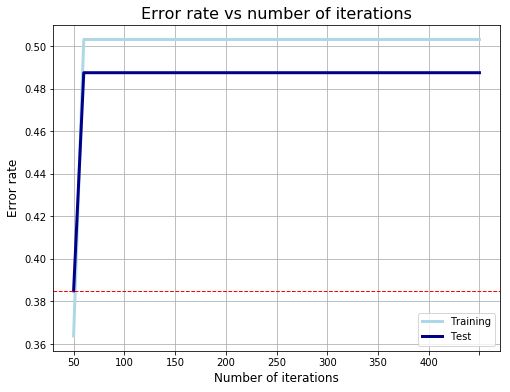

In [95]:
# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)

In [96]:
er_train[0:10]

[0.36375,
 0.503125,
 0.503125,
 0.503125,
 0.503125,
 0.503125,
 0.503125,
 0.503125,
 0.503125,
 0.503125]

In [97]:
er_test[0:11]

[0.385,
 0.4875,
 0.4875,
 0.4875,
 0.4875,
 0.4875,
 0.4875,
 0.4875,
 0.4875,
 0.4875,
 0.4875]

In [99]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix(Y_train, pred_train)